In [3]:
# %% -----------------------------------------------
# Accuracy–Fairness Tradeoff (Pareto) Plotter for ipynb
# - hardcoded config (no argparse)
# - method aliasing, control-parameter auto-detect
# - Pareto front + seed std errorbars
# --------------------------------------------------

import glob
import warnings
from typing import Dict, List, Optional
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)

# ============== CONFIG ==============
  # CSV 안의 dataset 값과 일치해야 함




/usr/local/miniconda3/envs/nine/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [17]:
def main(dataset, csv_patterns, nlow, agg_repeat,title, error_bar=False, path=""):
    # 분석할 CSV 파일 경로(글롭 패턴 가능). 필요에 맞게 수정하세요.
    

    # FAIRNESS_KEYS = "spd_mean"     # x축 공정성 지표(낮을수록 좋음): spd_worst, spd_mean, supipm_w1, supipm_rbf 등
    # FAIRNESS_KEYS = [ "supipm_rbf","supipm_w1","sup_mmd_dfcols","sup_w1_dfcols","sup_w1_over_V", "spd_worst","spd_mean",
    #                  "worst_weighted_group_spd","mean_weighted_group_spd", "worst_spd_over_V","mean_spd_over_V","worst_weighted_spd_over_V","mean_weighted_spd_over_V", 
    #                  "fpr_worst","fpr_mean","mc_worst","mc_mean",
    #                  "marg_spd_worst","marg_spd_mean","marg_fpr_worst","marg_fpr_mean","marg_mc_worst","marg_mc_mean" ]
    # FAIRNESS_KEYS = [ "supipm_rbf", "supipm_w1","sup_mmd_dfcols","sup_w1_dfcols","sup_mmd_over_V","sup_w1_over_V",]
    FAIRNESS_KEYS = [ "supipm_rbf", "supipm_w1","worst_weighted_group_spd", "worst_spd_over_V","marg_spd_worst"]


    SEED_AGG = "mean"              # "mean" 또는 "median"
    TITLE = dataset                # 플롯 제목
                # None 또는 "tradeoff_adult.png"
    XLIM = None                    # 예: (0.05, 0.25)
    YLIM = None                    # 예: (0.78, 0.86)
    ALPHA_POINTS = 0.6             # 산점도 투명도
    DPI = 220                      # 저장 dpi

    # 마커 지정(표준화된 메서드 이름 기준)
    MARKERS = {"dr": "o", "reduction": "s", "gerryfair": "^", "multicalib": "D", "sequential": "P"}

    # 메서드 이름 표준화(별칭)
    METHOD_CANON = {
        "dr": "dr",
        "dr_subgroup_subset": "dr",
        "dr_subgroup_subset_3q": "dr",
        "dr_subgroup_subset_random": "dr",
        "gerry": "gerryfair",
        "gerryfair": "gerryfair",
        "multicalib": "multicalib",
        "seq": "sequential",
        "sequential": "sequential",
        "red": "reduction",
        "reduction": "reduction",
        "reg":"reg"
    }

    # 1순위 컨트롤 파라미터 후보(스윕 축)
    CONTROL_COLS_PRIMARY = {
        "dr":          ["lambda_fair"],
        "reduction":   ["red_eps"],
        "gerryfair":   ["gamma"],
        "multicalib":  ["mc_alpha"],
        "sequential":  ["seq_alpha"],
        "reg"       :  ["mf_lambda"]
    }

    # 대체 컨트롤 후보(1순위가 단일값이면 여기서 탐색)
    CONTROL_COLS_FALLBACK = {
        "dr":          ["n_low", "n_low_frac", "shrink_smallest_frac"],
        "reduction":   ["red_constraint", "red_max_iter"],
        "gerryfair":   ["gf_max_iters", "gf_C"],
        "multicalib":  ["mc_lambda", "mc_max_iter"],
        "sequential":  ["seq_max_iter"],
    }
    # ====================================


    # ---------- helpers ----------
    def canon_method(m: str) -> str:
        if m is None:
            return "unknown"
        m = str(m)
        if m in METHOD_CANON:
            return METHOD_CANON[m]
        for k, v in METHOD_CANON.items():
            if m.startswith(k):
                return v
        return m

    def pick_control_col(sub_df: pd.DataFrame, method_raw: str) -> Optional[str]:
        base = canon_method(method_raw)
        for c in CONTROL_COLS_PRIMARY.get(base, []):
            if c in sub_df.columns and sub_df[c].nunique(dropna=True) > 1:
                return c
        for c in CONTROL_COLS_FALLBACK.get(base, []):
            if c in sub_df.columns and sub_df[c].nunique(dropna=True) > 1:
                return c
        return None

    def pareto_front_xy(x, y, eps=1e-9):
        """
        x 낮을수록(공정), y 높을수록(정확) 좋은 경우의 비지배 집합 index 반환.
        정렬(x asc, y desc) 후 누적 best y 유지.
        """
        x = np.asarray(x, float)
        y = np.asarray(y, float)
        ok = np.isfinite(x) & np.isfinite(y)
        base_idx = np.arange(len(x))[ok]
        if base_idx.size == 0:
            return np.array([], dtype=int)

        order = np.lexsort((-y[ok], x[ok]))  # x asc, y desc
        xs = x[ok][order]
        ys = y[ok][order]
        idxs = base_idx[order]

        keep = []
        best_y = -np.inf
        for xi, yi, ii in zip(xs, ys, idxs):
            if yi >= best_y - eps:
                keep.append(ii)
                if yi > best_y:
                    best_y = yi
        return np.array(sorted(keep, key=lambda i: x[i]), dtype=int)

    def coerce_float_safe(v) -> float:
        try:
            return float(v)
        except Exception:
            return np.nan


    # ---------- load ----------
    file_list: List[str] = []
    for pat in csv_patterns:
        file_list.extend(sorted(glob.glob(pat)))
    if not file_list:
        raise FileNotFoundError("CSV_PATTERNS에 맞는 파일이 없습니다. 경로/패턴을 확인하세요.")

    frames = []
    for fp in file_list:
        try:
            df = pd.read_csv(fp)
            # # (1) 컬럼명 오타 정정 (CSV에 'agg_repeart'로 저장돼있다면 rename으로 통일)
            # df = df.rename(columns={"agg_repeart": "agg_repeat"})

            # # (2) 행 필터 한 줄로 끝
            # df = df[(df["method"] != "dr_subgroup_subset_random") | (df["agg_repeat"] == agg_repeat)].copy()
            df["__source_file"] = fp
            frames.append(df)
        except Exception as e:
            print(f"[WARN] 읽기 실패: {fp} ({e})")

    df_all = pd.concat(frames, ignore_index=True, sort=False)
    print(f"[INFO] loaded rows={len(df_all)}, files={len(file_list)}")

    # ---------- filter & derive ----------
    if "dataset" not in df_all.columns:
        raise KeyError("CSV에 'dataset' 컬럼이 없습니다.")
    df = df_all[df_all["dataset"] == dataset].copy()
    if df.empty:
        raise ValueError(f"dataset=='{dataset}' 인 행이 없습니다.")

    for FAIRNESS_KEY in FAIRNESS_KEYS:
        os.makedirs(path, exist_ok = True)
        SAVE_PATH = path + dataset + f"_{FAIRNESS_KEY}.png"  # 저장 경로
        if FAIRNESS_KEY not in df.columns:
            raise KeyError(f"CSV에 '{FAIRNESS_KEY}' 컬럼이 없습니다.")
        df["fairness_scalar"] = df[FAIRNESS_KEY].map(coerce_float_safe)

        if "accuracy" not in df.columns:
            raise KeyError("CSV에 'accuracy' 컬럼이 없습니다.")
        df["accuracy"] = df["accuracy"].map(coerce_float_safe)

        df = df[np.isfinite(df["fairness_scalar"]) & np.isfinite(df["accuracy"])].copy()
        if df.empty:
            raise ValueError("유효한 fairness_scalar/accuracy 값이 없습니다.")

        if "method" not in df.columns:
            raise KeyError("CSV에 'method' 컬럼이 없습니다.")
        methods = sorted(df["method"].dropna().unique().tolist())
        print("[INFO] methods(raw):", methods)

        agg_fun = np.mean if SEED_AGG == "mean" else np.median

        # 색상(표준 메서드 단위로 고정)
        base_methods = sorted(set(canon_method(m) for m in methods))
        cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
        COLOR_BY_BASE = {bm: cmap(i % cmap.N) for i, bm in enumerate(base_methods)}

        # ---------- plot ----------
        plt.figure(figsize=(7.8, 5.6))
        method_label_used: Dict[str, bool] = {}

        for m in methods:
            print(f"[INFO] method={m:>24s}")
            sub = df[df["method"] == m].copy()
            if sub.empty:
                continue
            # print(sub)

            base = canon_method(m)
            color = COLOR_BY_BASE.get(base, "C0")
            marker = MARKERS.get(base, "o")
            ctrl = pick_control_col(sub, m)
            print(f"[INFO] method={m:>24s} -> base={base:>11s}, ctrl={ctrl}")

            if ctrl is None:
                # 컨트롤 스윕 없음: 모든 점 산점도 + Pareto-front 선
                pts = sub[["fairness_scalar", "accuracy"]].dropna()
                if pts.empty:
                    continue
                lbl = base if not method_label_used.get(base, False) else None
                plt.scatter(pts["fairness_scalar"], pts["accuracy"],
                            s=26, marker=marker, color=color, alpha=ALPHA_POINTS,
                            label=lbl, zorder=2)
                method_label_used[base] = True

                pf_idx = pareto_front_xy(pts["fairness_scalar"].values, pts["accuracy"].values, eps=1e-9)
                if pf_idx.size > 1:
                    front = pts.iloc[pf_idx].sort_values("fairness_scalar", ascending=False)
                    plt.plot(front["fairness_scalar"], front["accuracy"],
                            "-", color=color, linewidth=2.0, alpha=0.9, zorder=3)

            else:
                # (ctrl, seed)별 집계 → ctrl별 평균/표준편차
                needed = ["fairness_scalar", "accuracy", "seed", ctrl]
                missing = [c for c in needed if c not in sub.columns]
                if missing:
                    print(f"[WARN] {m}: 누락 컬럼 {missing} → 산점도로 대체")
                    pts = sub[["fairness_scalar", "accuracy"]].dropna()
                    if pts.empty:
                        continue
                    lbl = base if not method_label_used.get(base, False) else None
                    plt.scatter(pts["fairness_scalar"], pts["accuracy"],
                                s=26, marker=marker, color=color, alpha=ALPHA_POINTS,
                                label=lbl, zorder=2)
                    method_label_used[base] = True
                    continue

                grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
                    fair=("fairness_scalar", agg_fun),
                    acc=("accuracy",       agg_fun),
                ).reset_index().rename(columns={ctrl: "ctrl"})

                agg = grp.groupby("ctrl", dropna=False).agg(
                    x=("fair", agg_fun),
                    y=("acc",  agg_fun),
                    x_std=("fair", "std"),
                    y_std=("acc",  "std"),
                    n=("fair", "count"),
                ).reset_index()

                if agg.empty:
                    continue

                agg["x_std"] = agg["x_std"].fillna(0.0)
                agg["y_std"] = agg["y_std"].fillna(0.0)

                pf_idx = pareto_front_xy(agg["x"].values, agg["y"].values, eps=1e-9)
                best_acc_idx = agg["y"].idxmax()
                use_idx = sorted(set(pf_idx.tolist() + [best_acc_idx]), key=lambda i: agg.loc[i, "x"])
                front = agg.iloc[use_idx].copy().sort_values("x", ascending=False).reset_index(drop=True)

                lbl = base if not method_label_used.get(base, False) else None
                if error_bar:
                    plt.errorbar(agg["x"], agg["y"],
                                xerr=agg["x_std"], yerr=agg["y_std"],
                                fmt=marker, color=color, ecolor=color,
                                elinewidth=1.1, capsize=3, linestyle="none",
                                label=lbl, zorder=3)
                else:

                    # 교체(에러바 제거, 산점도만)
                    plt.scatter(agg["x"], agg["y"],
                                s=26, marker=marker, color=color, alpha=ALPHA_POINTS,
                                label=lbl, zorder=3)


                method_label_used[base] = True

                if len(front) >= 2:
                    plt.plot(front["x"], front["y"], "-", color=color, linewidth=2.0, alpha=0.95, zorder=2)

        # ---------- cosmetics ----------
        plt.xlabel(f"Fairness ({FAIRNESS_KEY}; lower is better)")
        plt.ylabel("Accuracy")
        plt.title(f"{TITLE}  (Pareto front, seed std)")

        if XLIM: plt.xlim(XLIM)
        if YLIM: plt.ylim(YLIM)

        plt.grid(alpha=0.3, linewidth=0.7)
        plt.title(title)
        leg = plt.legend(title="method", frameon=True)
        if leg:
            leg.get_frame().set_alpha(0.9)
        plt.tight_layout()

        if SAVE_PATH:
            plt.show()
            plt.savefig(SAVE_PATH, dpi=DPI)
            print(f"[INFO] saved -> {SAVE_PATH}")
        else:
            plt.show()


=== nlow=1e-05, agg_repeat=4096 ===
[INFO] loaded rows=213, files=4
[INFO] methods(raw): ['gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(


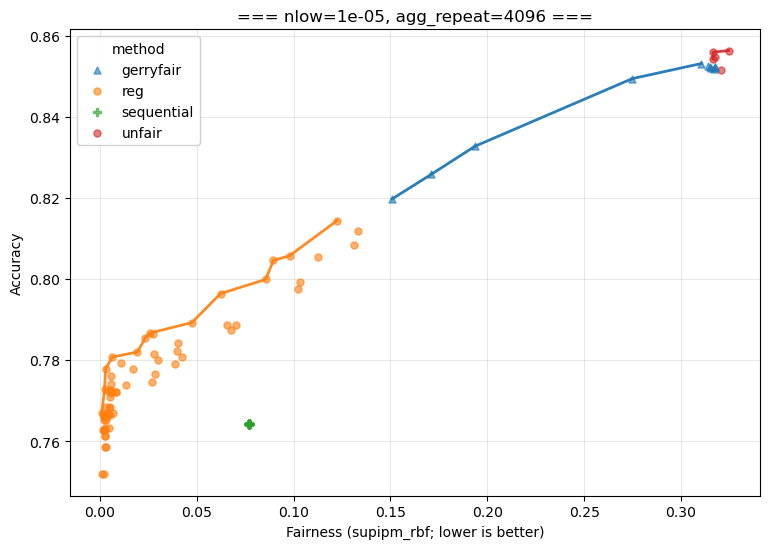

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
[INFO] methods(raw): ['gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

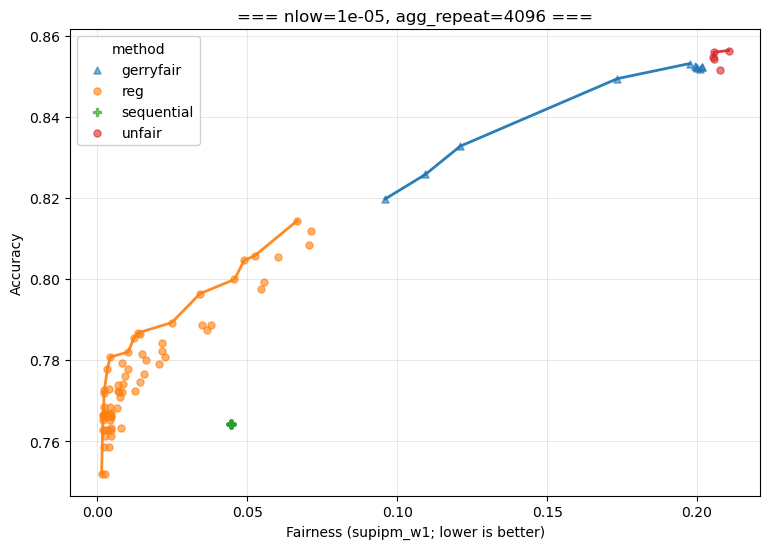

[INFO] saved -> ../plots/tradeoff/adult_supipm_w1.png
[INFO] methods(raw): ['gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(


[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(


<Figure size 640x480 with 0 Axes>

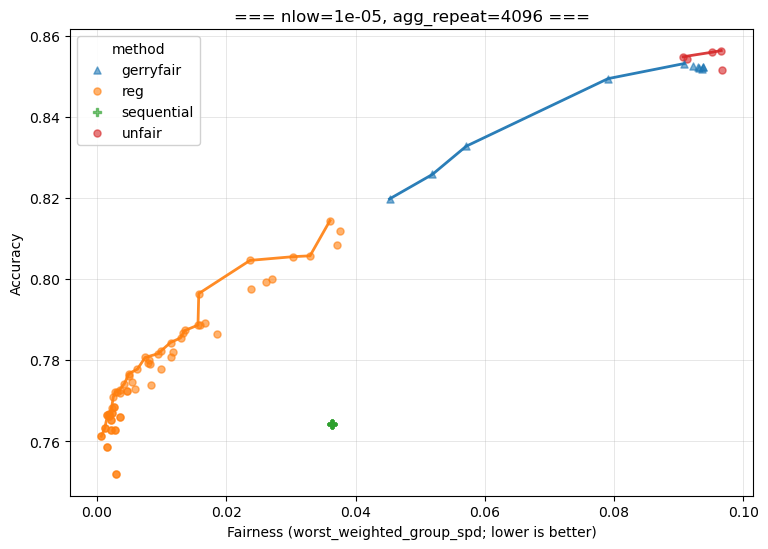

[INFO] saved -> ../plots/tradeoff/adult_worst_weighted_group_spd.png
[INFO] methods(raw): ['gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

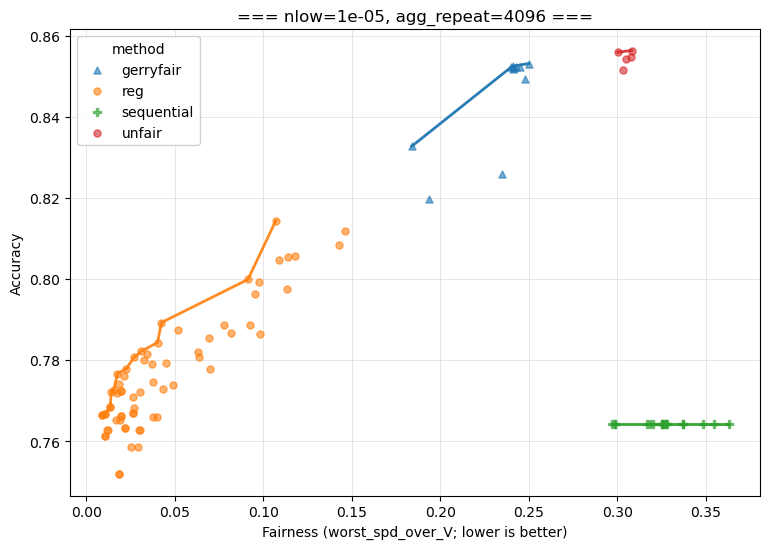

[INFO] saved -> ../plots/tradeoff/adult_worst_spd_over_V.png
[INFO] methods(raw): ['gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

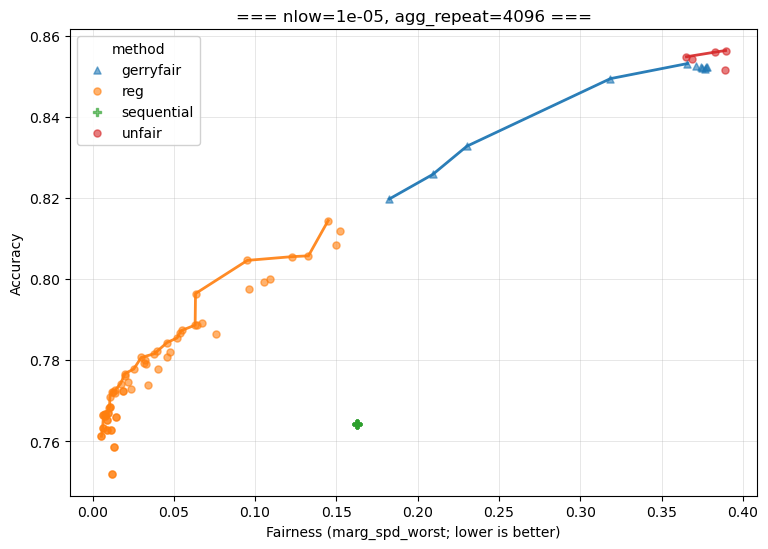

[INFO] saved -> ../plots/tradeoff/adult_marg_spd_worst.png
=== nlow=0.125, agg_repeat=4096 ===
[INFO] loaded rows=292, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(


[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=

<Figure size 640x480 with 0 Axes>

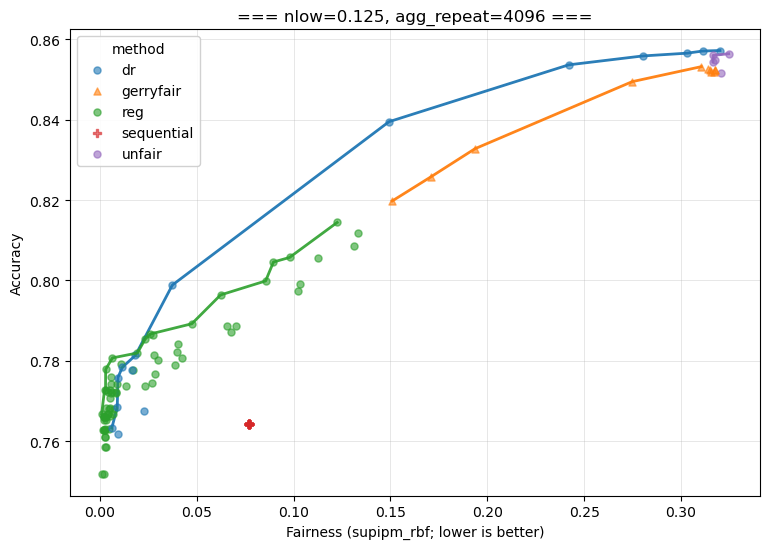

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

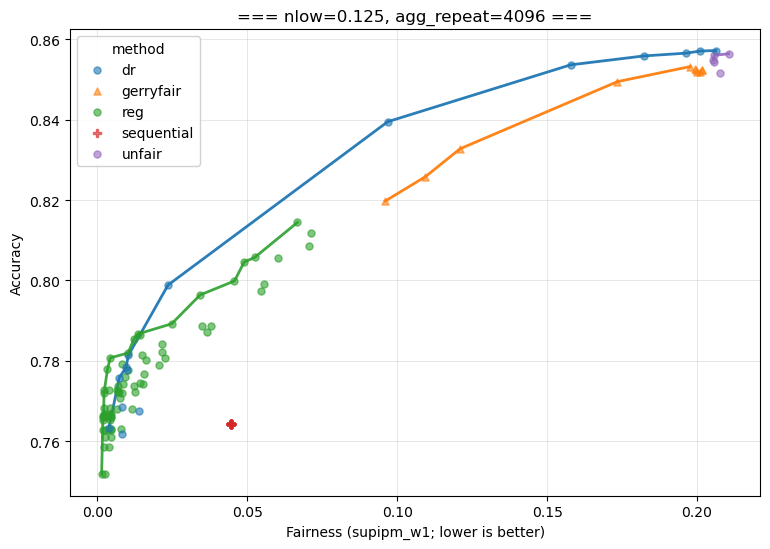

[INFO] saved -> ../plots/tradeoff/adult_supipm_w1.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

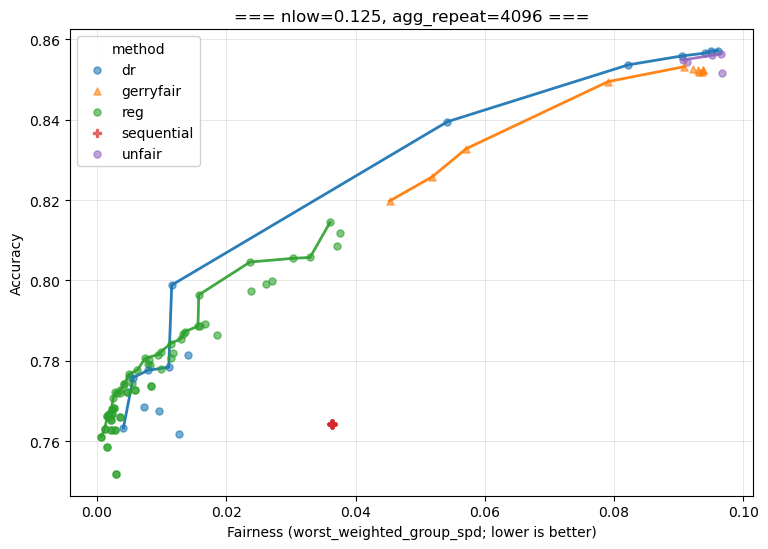

[INFO] saved -> ../plots/tradeoff/adult_worst_weighted_group_spd.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

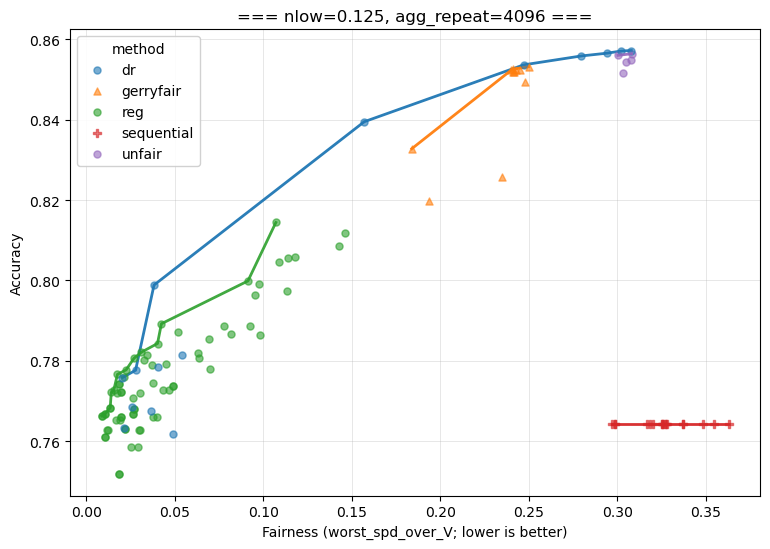

[INFO] saved -> ../plots/tradeoff/adult_worst_spd_over_V.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

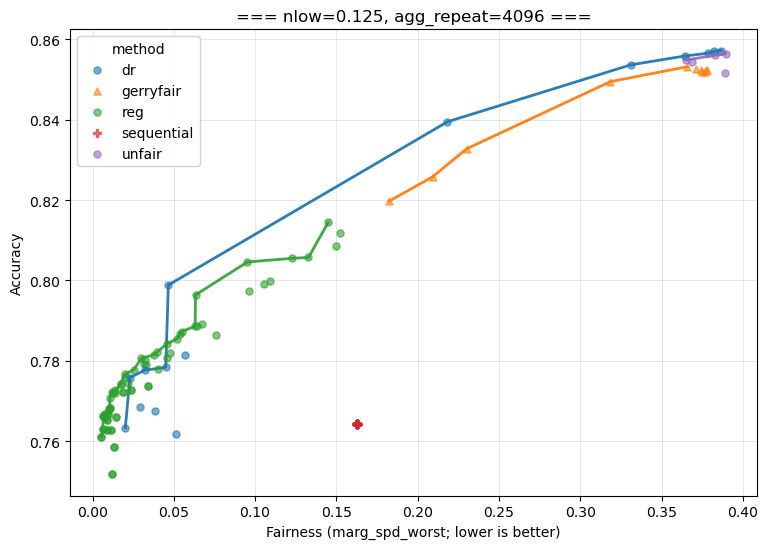

[INFO] saved -> ../plots/tradeoff/adult_marg_spd_worst.png
=== nlow=0.25, agg_repeat=4096 ===
[INFO] loaded rows=294, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

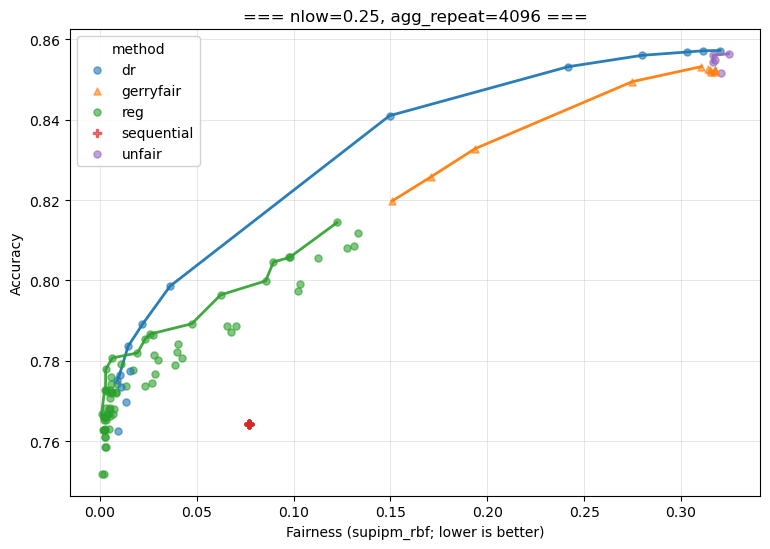

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

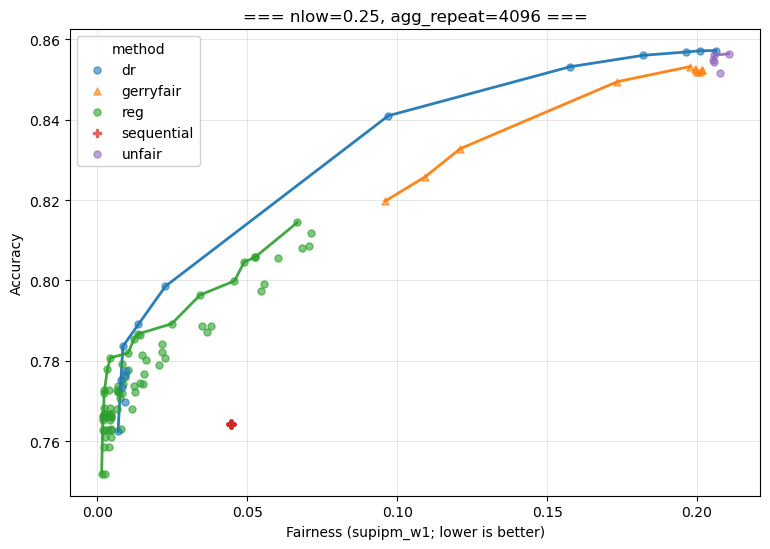

[INFO] saved -> ../plots/tradeoff/adult_supipm_w1.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

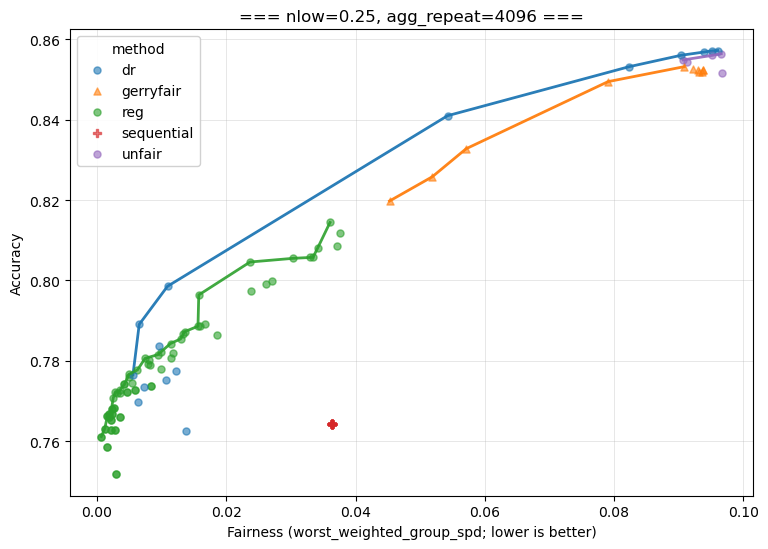

[INFO] saved -> ../plots/tradeoff/adult_worst_weighted_group_spd.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

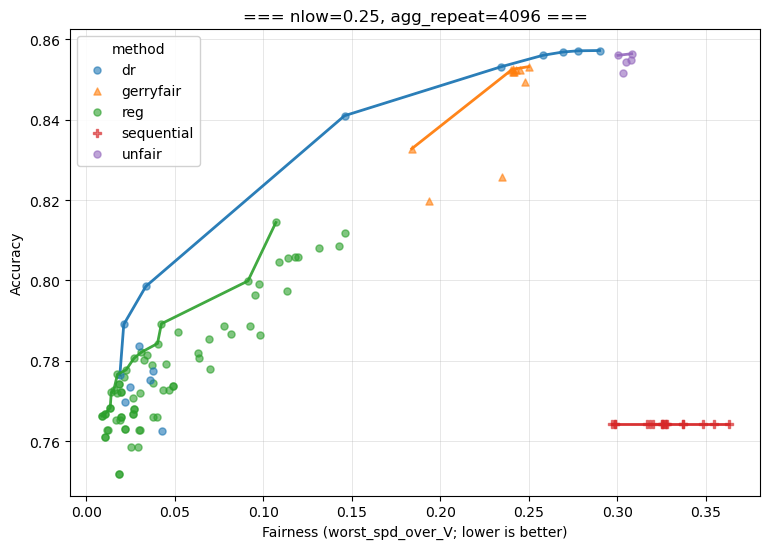

[INFO] saved -> ../plots/tradeoff/adult_worst_spd_over_V.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(


<Figure size 640x480 with 0 Axes>

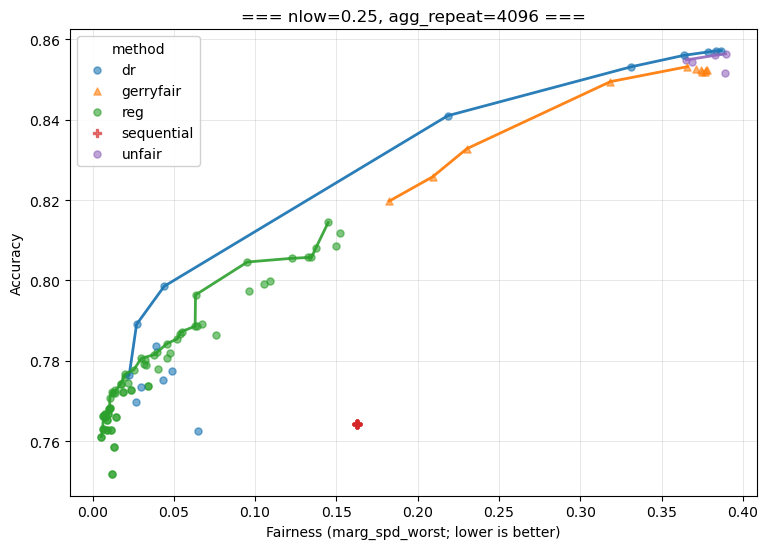

[INFO] saved -> ../plots/tradeoff/adult_marg_spd_worst.png
=== nlow=0.5, agg_repeat=4096 ===
[INFO] loaded rows=297, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(


[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=

<Figure size 640x480 with 0 Axes>

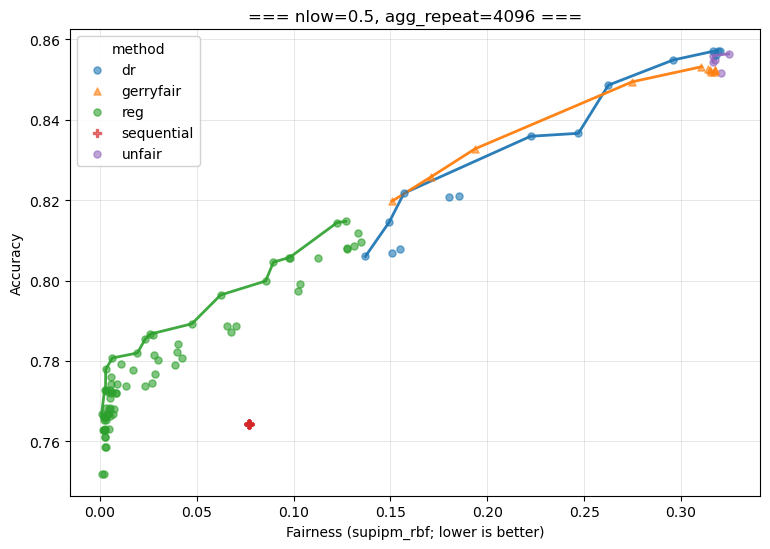

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

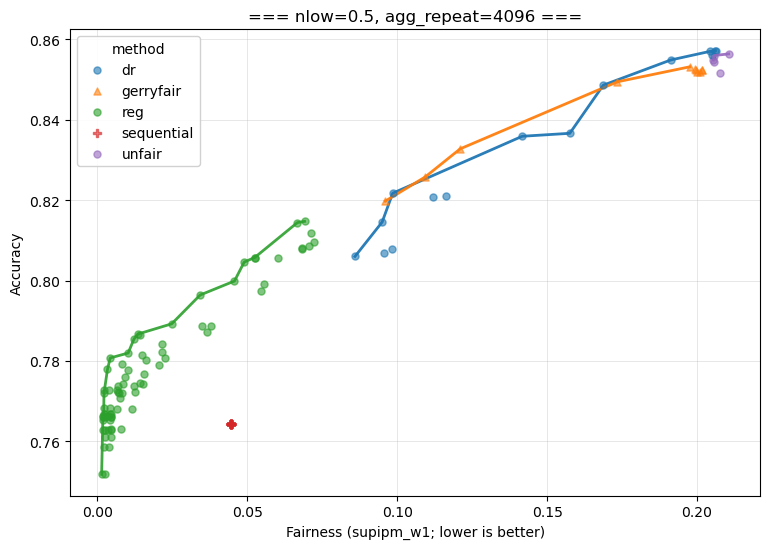

[INFO] saved -> ../plots/tradeoff/adult_supipm_w1.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

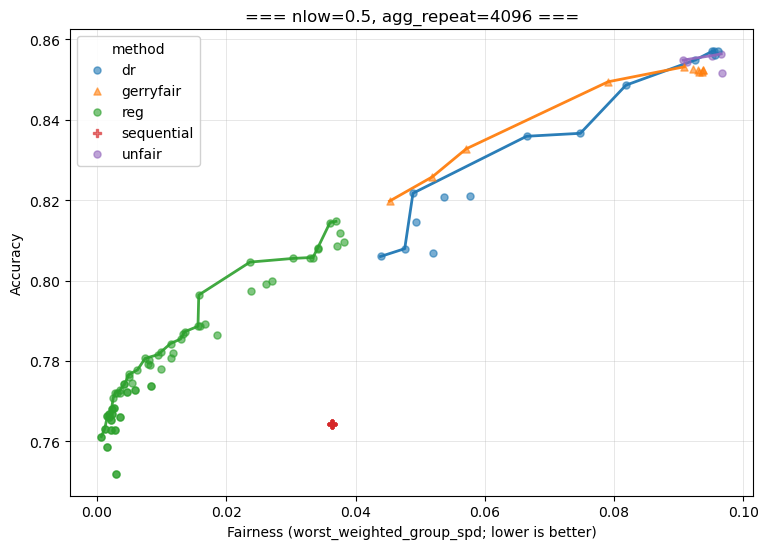

[INFO] saved -> ../plots/tradeoff/adult_worst_weighted_group_spd.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

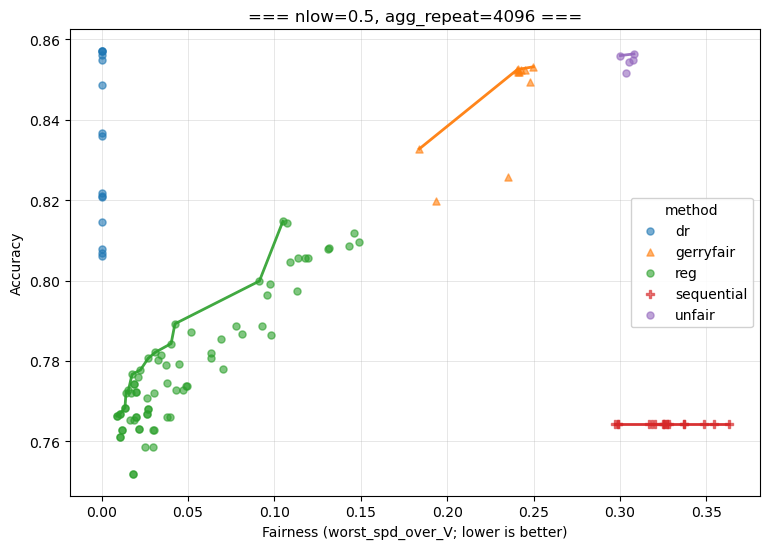

[INFO] saved -> ../plots/tradeoff/adult_worst_spd_over_V.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

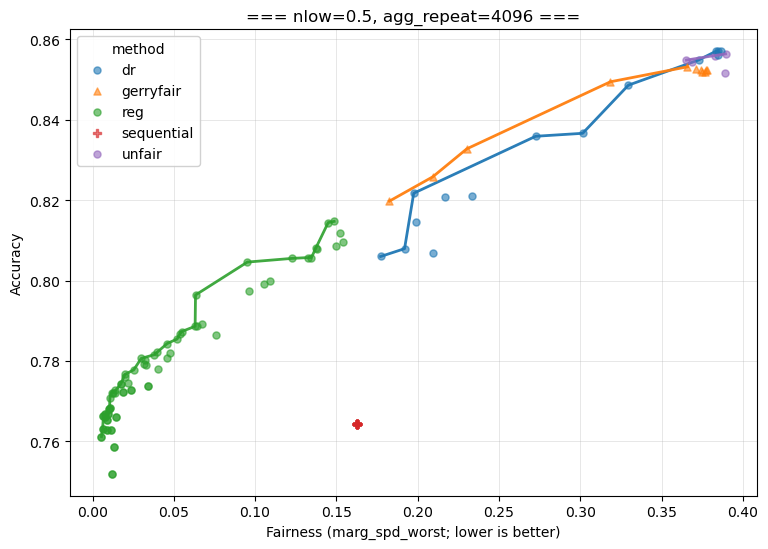

[INFO] saved -> ../plots/tradeoff/adult_marg_spd_worst.png


<Figure size 640x480 with 0 Axes>

In [18]:
dataset = "adult"


for nlow in [0.00001, 0.125, 0.25, 0.5, ]:
    for agg_repeat in [4096]:
        csv_patterns = [
        f"../0914_results/{nlow}/dr_{dataset}/all_results.csv",          # 예: DR
        # f"../0914_results/reduction_{dataset}/all_results.csv", # 예: Reduction
        f"../0914_results/gerryfair_{dataset}/all_results.csv", # 예: GerryFair
        f"../0914_results/mc_{dataset}/all_results.csv",        # 예: Multicalibration
        f"../0914_results/sequential_{dataset}/all_results.csv",
        f"../0914_results/unfair_{dataset}/all_results.csv",       # 예: Sequential
        f"../0914_results/reg_{dataset}/all_results.csv",       
    ]
        print(f"=== nlow={nlow}, agg_repeat={agg_repeat} ===")
        main(dataset, csv_patterns, nlow, agg_repeat, title = f"=== nlow={nlow}, agg_repeat={agg_repeat} ===", path = "../plots/tradeoff/")

=== nlow=0.125, agg_repeat=4096 ===
[INFO] loaded rows=300, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

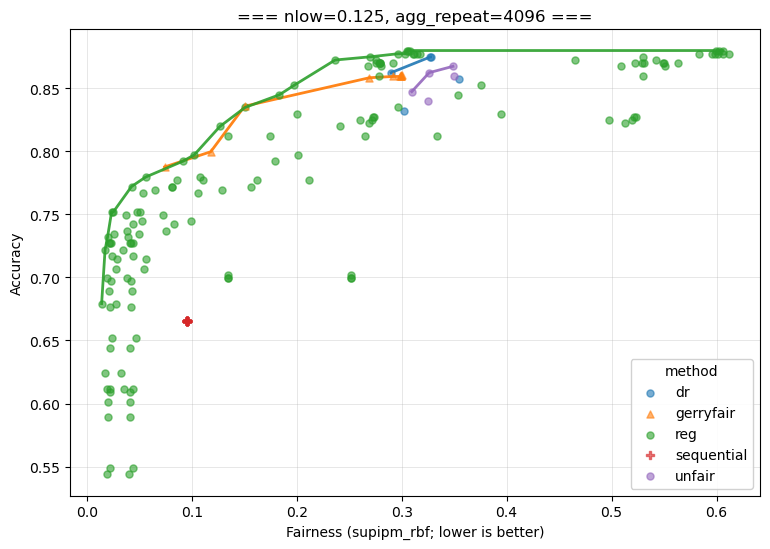

[INFO] saved -> ../plots/tradeoff/communities_supipm_rbf.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

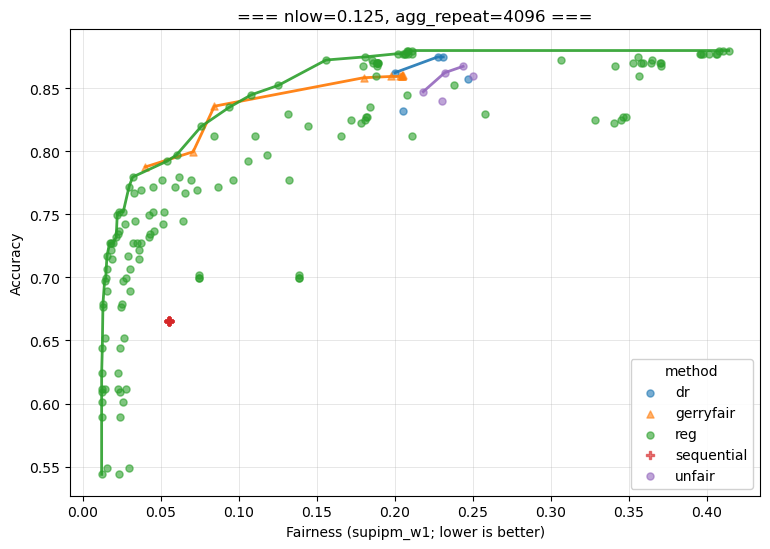

[INFO] saved -> ../plots/tradeoff/communities_supipm_w1.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

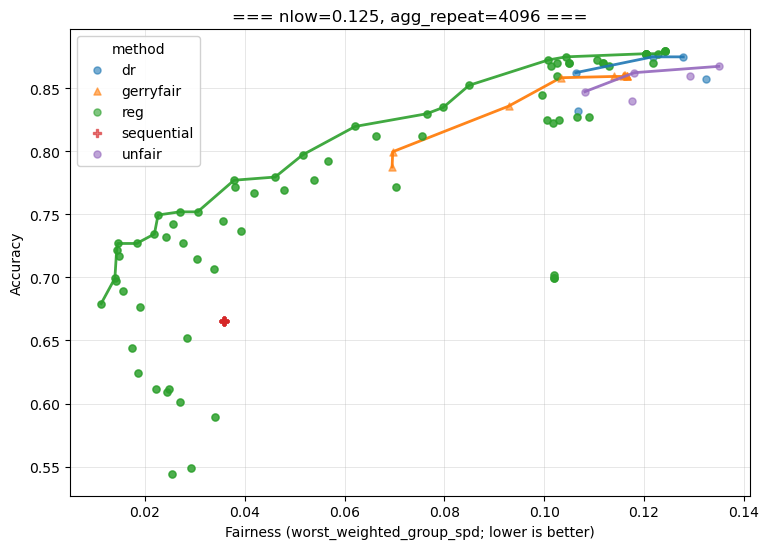

[INFO] saved -> ../plots/tradeoff/communities_worst_weighted_group_spd.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

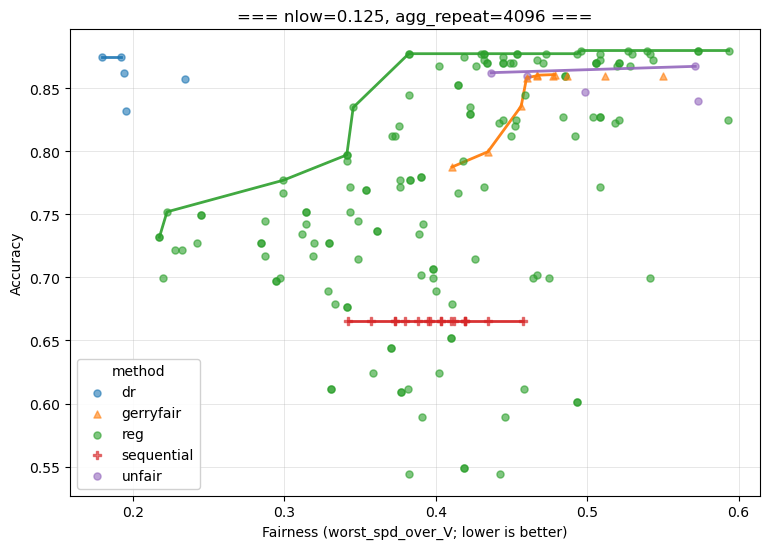

[INFO] saved -> ../plots/tradeoff/communities_worst_spd_over_V.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

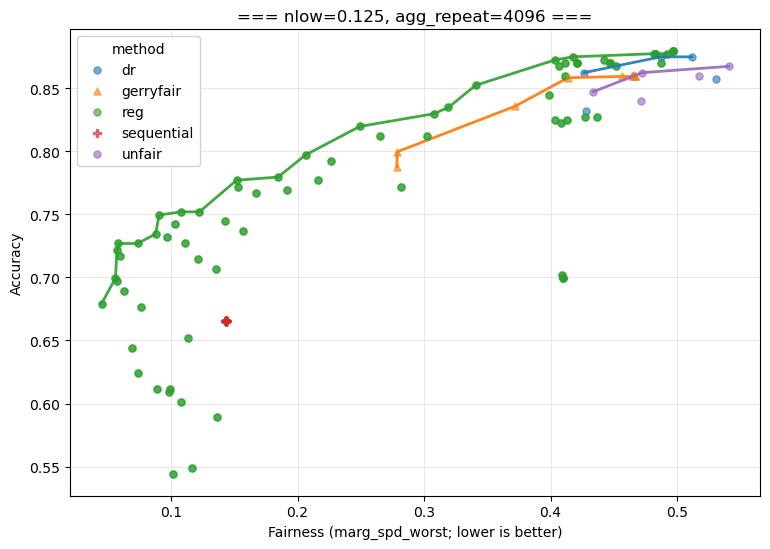

[INFO] saved -> ../plots/tradeoff/communities_marg_spd_worst.png
=== nlow=0.25, agg_repeat=4096 ===
[INFO] loaded rows=300, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

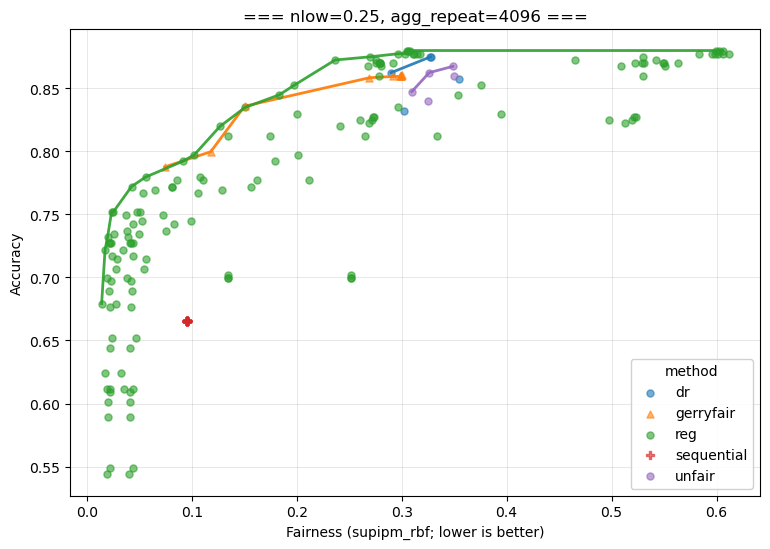

[INFO] saved -> ../plots/tradeoff/communities_supipm_rbf.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

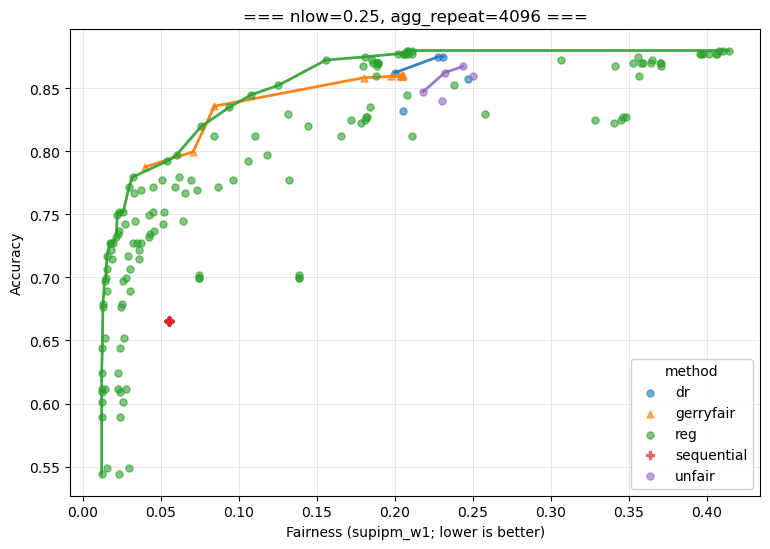

[INFO] saved -> ../plots/tradeoff/communities_supipm_w1.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

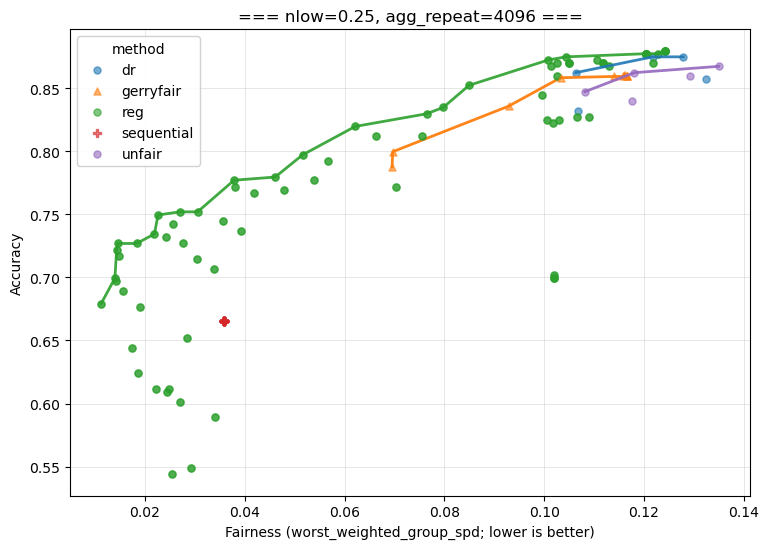

[INFO] saved -> ../plots/tradeoff/communities_worst_weighted_group_spd.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

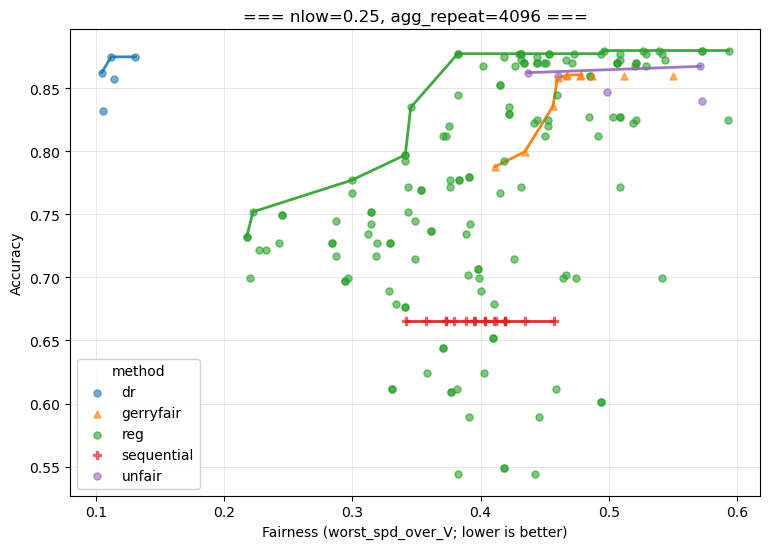

[INFO] saved -> ../plots/tradeoff/communities_worst_spd_over_V.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(


[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).a

<Figure size 640x480 with 0 Axes>

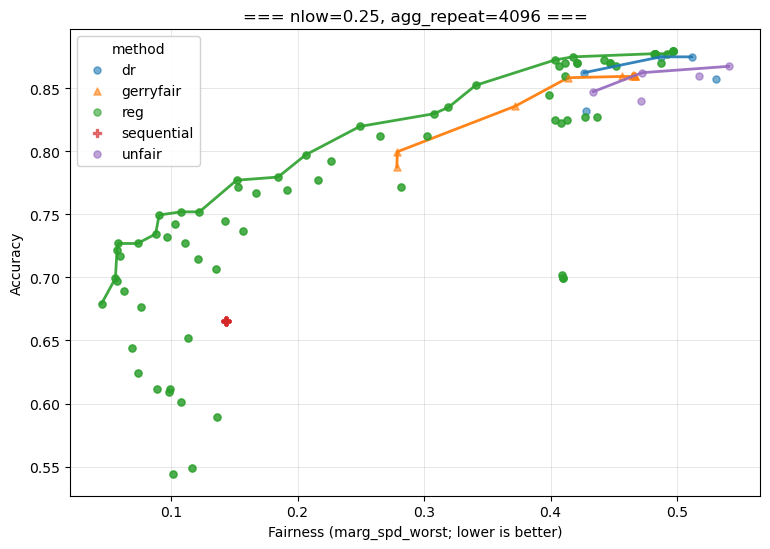

[INFO] saved -> ../plots/tradeoff/communities_marg_spd_worst.png
=== nlow=0.5, agg_repeat=4096 ===
[INFO] loaded rows=300, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

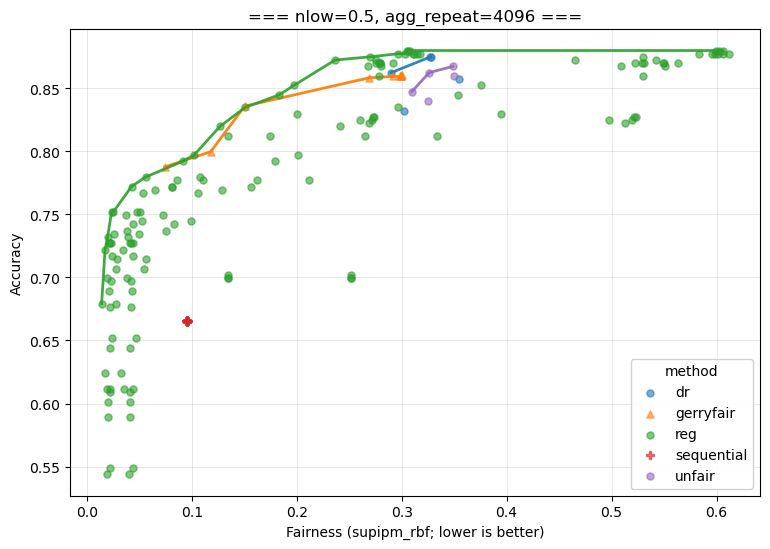

[INFO] saved -> ../plots/tradeoff/communities_supipm_rbf.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

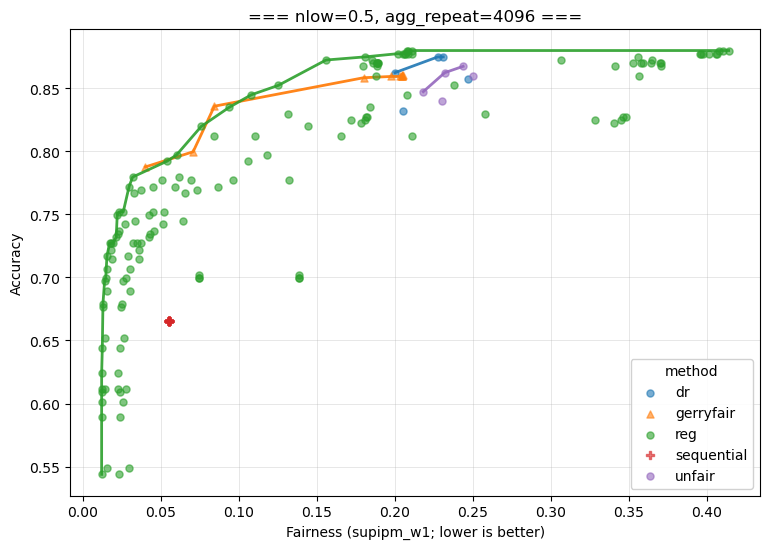

[INFO] saved -> ../plots/tradeoff/communities_supipm_w1.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

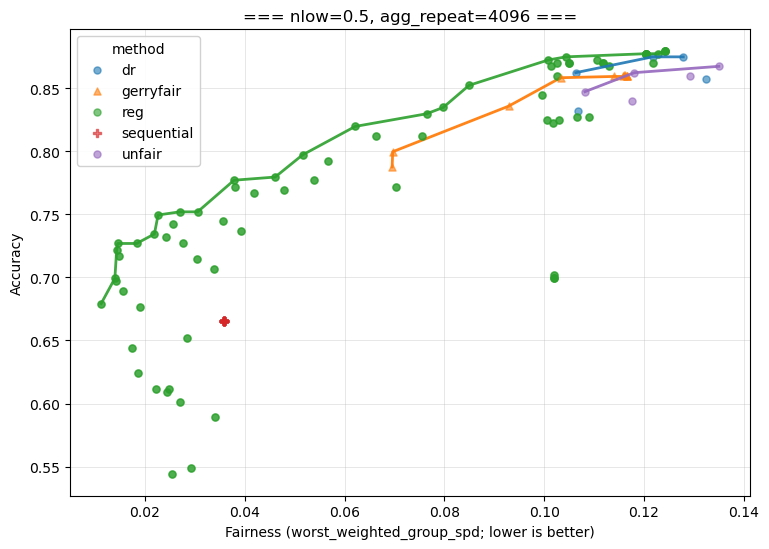

[INFO] saved -> ../plots/tradeoff/communities_worst_weighted_group_spd.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

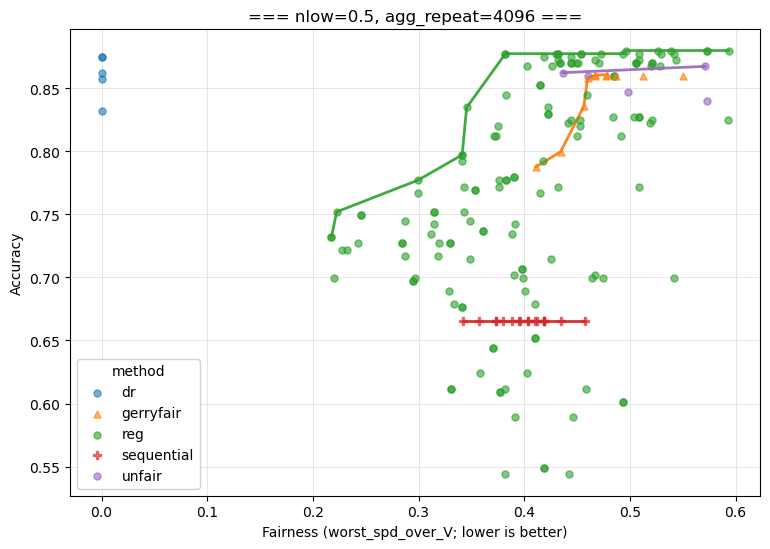

[INFO] saved -> ../plots/tradeoff/communities_worst_spd_over_V.png
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reg', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=None
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=                     reg
[INFO] method=                     reg -> base=        reg, ctrl=None
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_2938528/1507027476.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_2938528/1507027476.py:225: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_2938528/1507027476.py:230: FutureWarning: The provided callable <function mean at 0x7f74e18da670> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

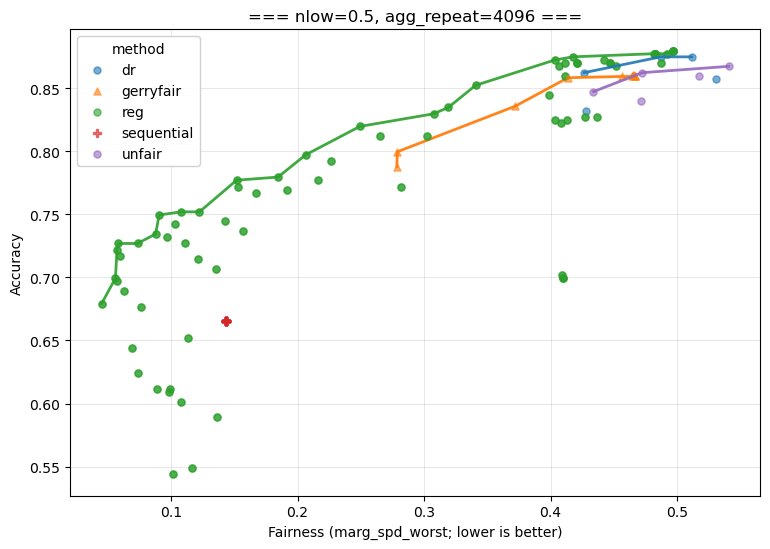

[INFO] saved -> ../plots/tradeoff/communities_marg_spd_worst.png


<Figure size 640x480 with 0 Axes>

In [20]:
dataset = "communities"


for nlow in [ 0.125, 0.25, 0.5, ]:
    for agg_repeat in [4096]:
        csv_patterns = [
        f"../0914_results/{nlow}/dr_{dataset}/all_results.csv",          # 예: DR
        # f"../0914_results/reduction_{dataset}/all_results.csv", # 예: Reduction
        f"../0914_results/gerryfair_{dataset}/all_results.csv", # 예: GerryFair
        f"../0914_results/mc_{dataset}/all_results.csv",        # 예: Multicalibration
        f"../0914_results/sequential_{dataset}/all_results.csv",
        f"../0914_results/unfair_{dataset}/all_results.csv",       # 예: Sequential
        f"../0914_results/reg_{dataset}/all_results.csv",       
    ]
        print(f"=== nlow={nlow}, agg_repeat={agg_repeat} ===")
        main(dataset, csv_patterns, nlow, agg_repeat, title = f"=== nlow={nlow}, agg_repeat={agg_repeat} ===", path = "../plots/tradeoff/")

=== nlow=10, agg_repeat=4 ===
[INFO] loaded rows=255, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


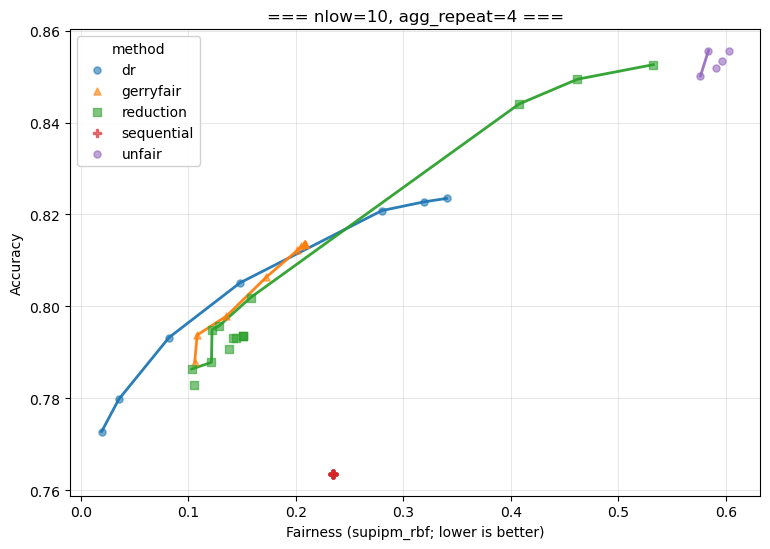

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=10, agg_repeat=16 ===
[INFO] loaded rows=255, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

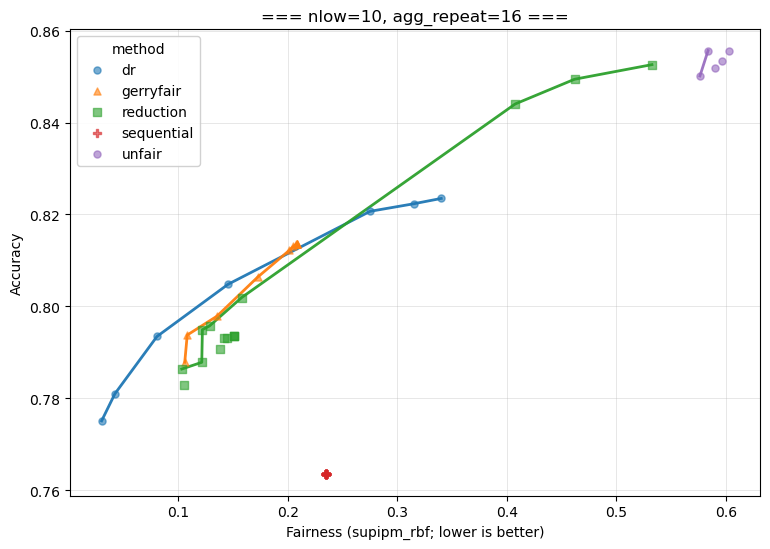

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=10, agg_repeat=64 ===
[INFO] loaded rows=255, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

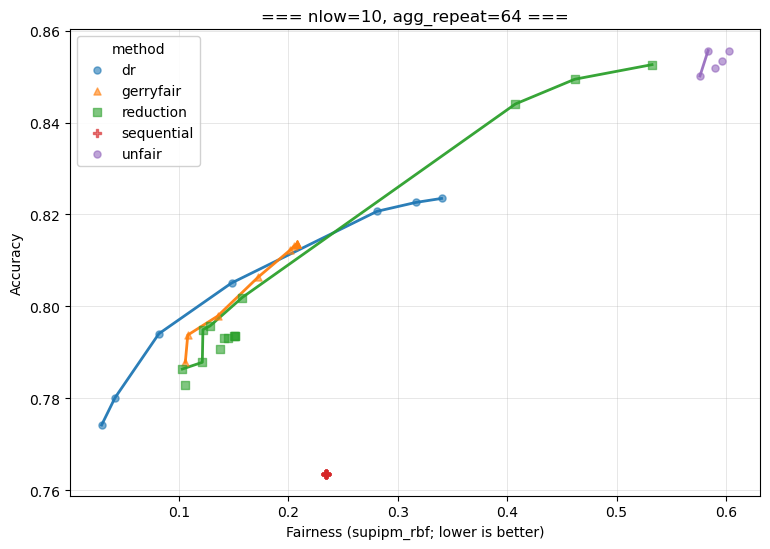

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=10, agg_repeat=256 ===
[INFO] loaded rows=255, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

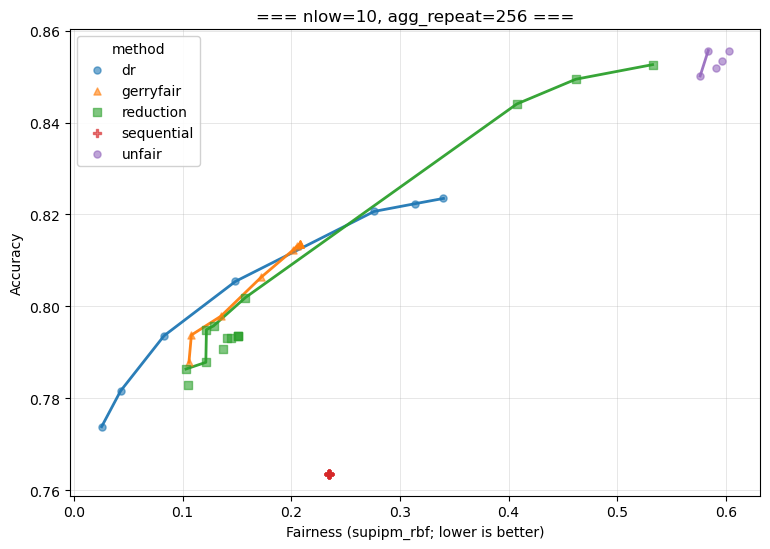

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=10, agg_repeat=1024 ===
[INFO] loaded rows=255, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

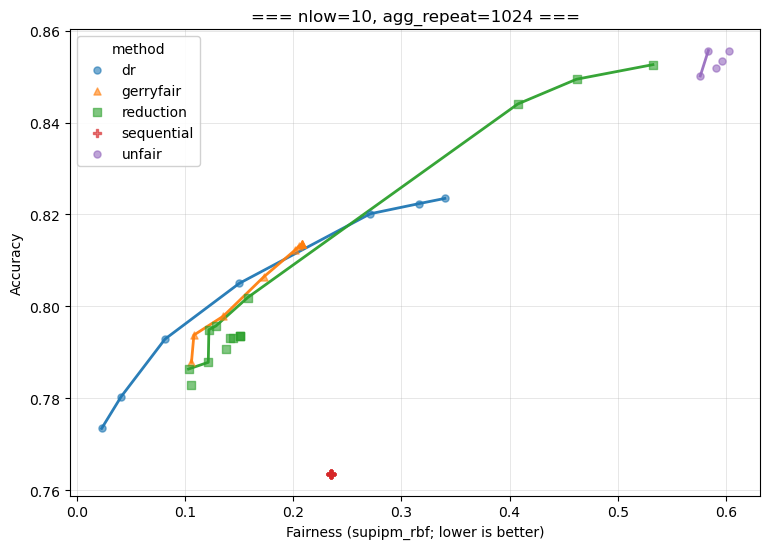

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=10, agg_repeat=4096 ===
[INFO] loaded rows=255, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

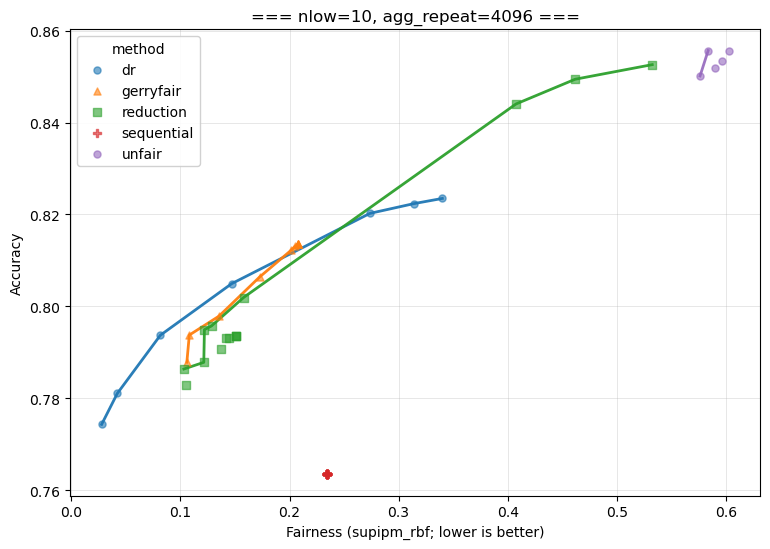

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=20, agg_repeat=4 ===
[INFO] loaded rows=254, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

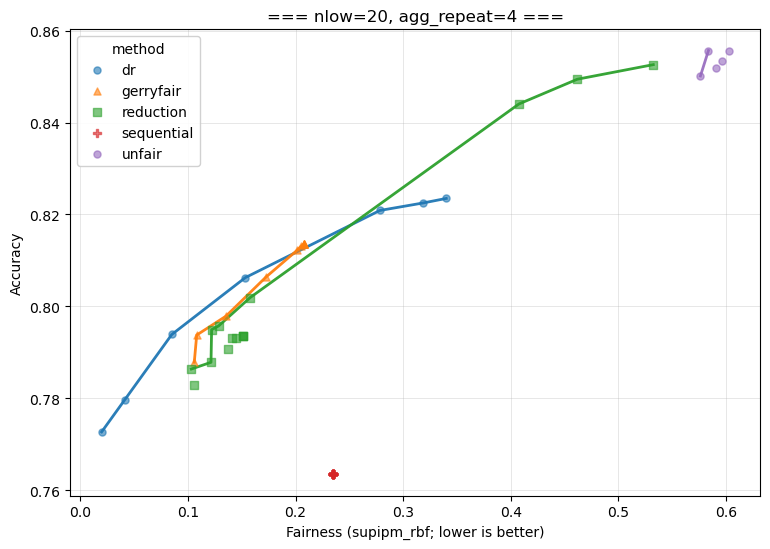

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=20, agg_repeat=16 ===
[INFO] loaded rows=254, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

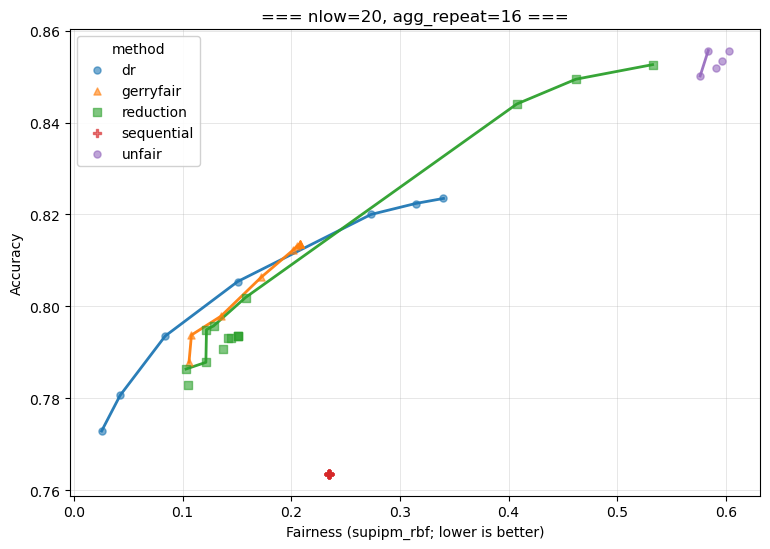

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=20, agg_repeat=64 ===
[INFO] loaded rows=253, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

<Figure size 640x480 with 0 Axes>

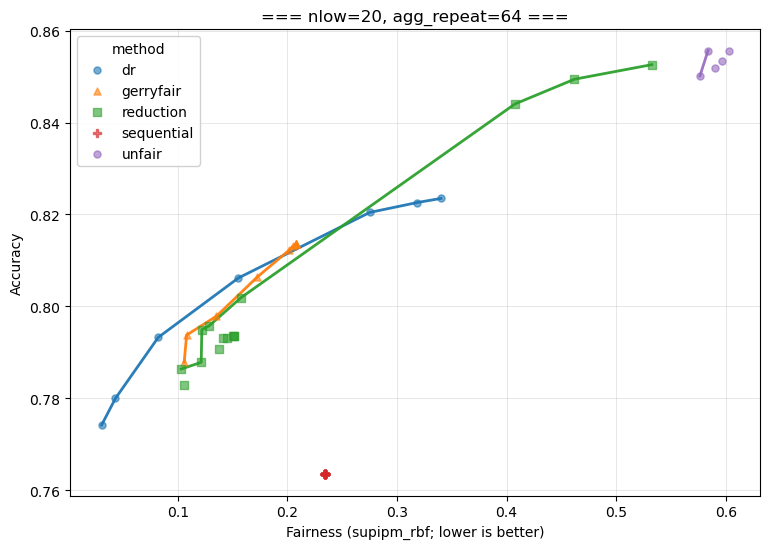

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=20, agg_repeat=256 ===
[INFO] loaded rows=253, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

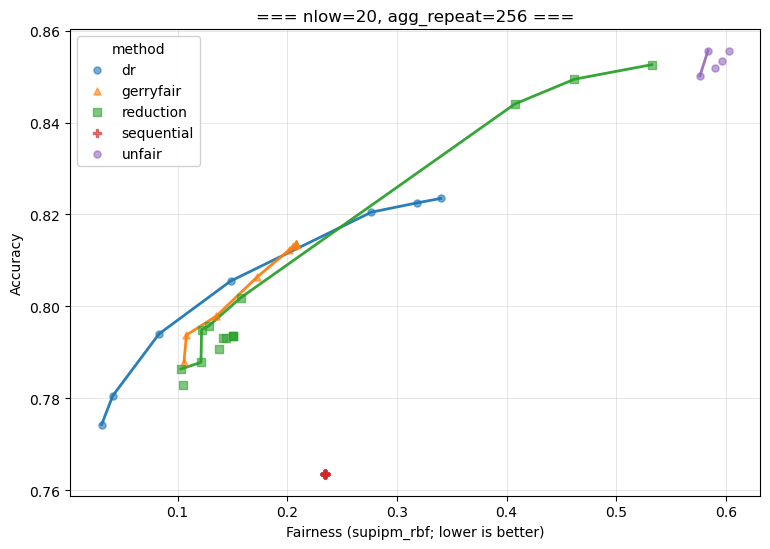

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=20, agg_repeat=1024 ===
[INFO] loaded rows=253, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

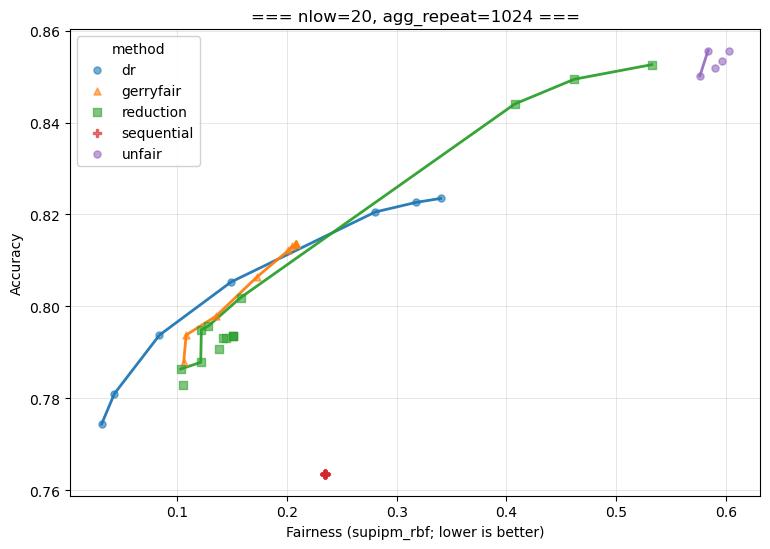

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=20, agg_repeat=4096 ===
[INFO] loaded rows=253, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

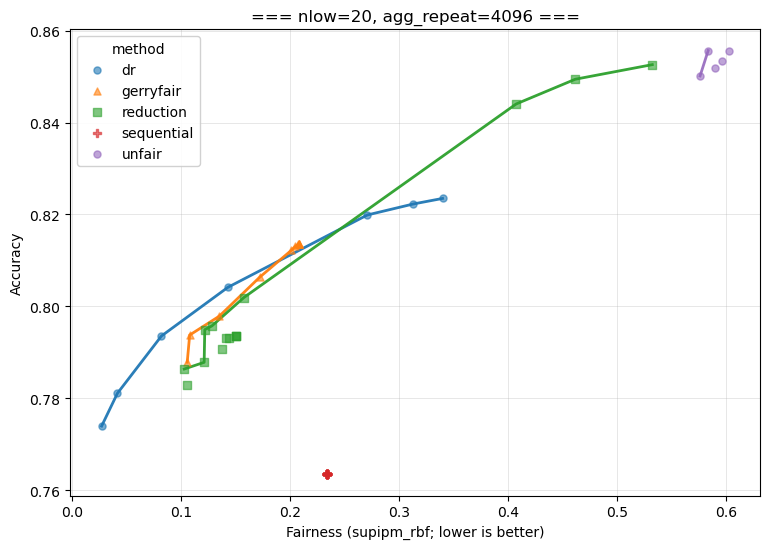

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=50, agg_repeat=4 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

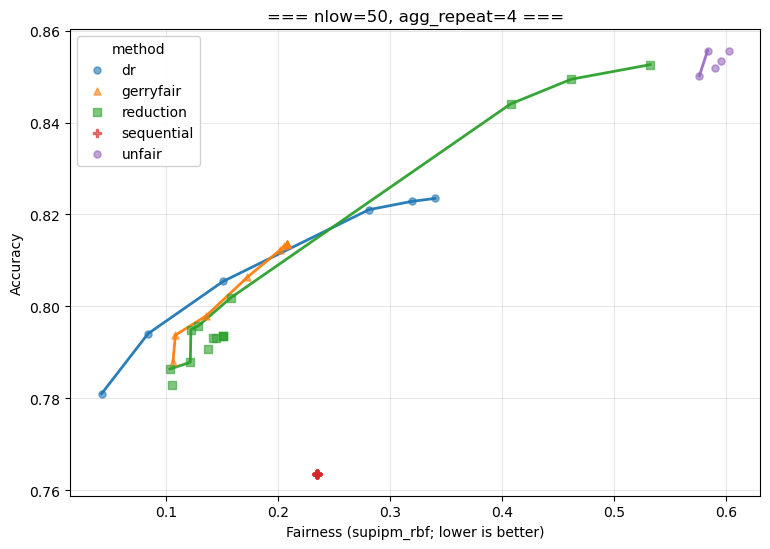

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=50, agg_repeat=16 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(


[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=

<Figure size 640x480 with 0 Axes>

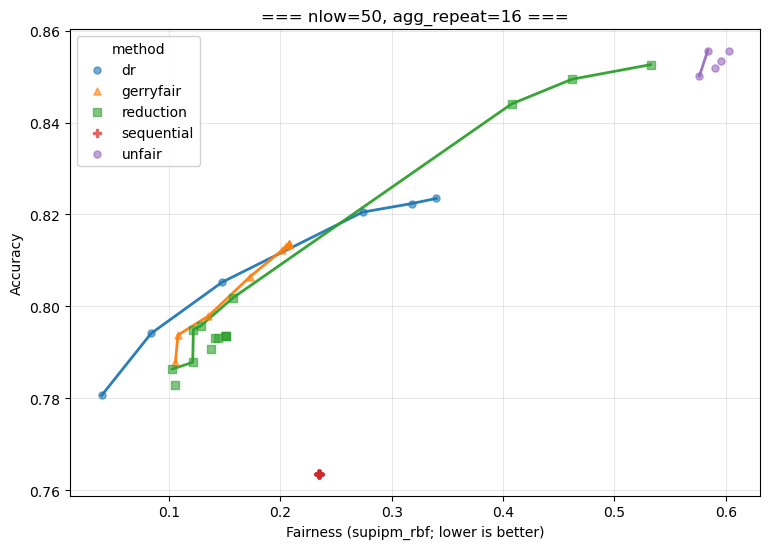

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=50, agg_repeat=64 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

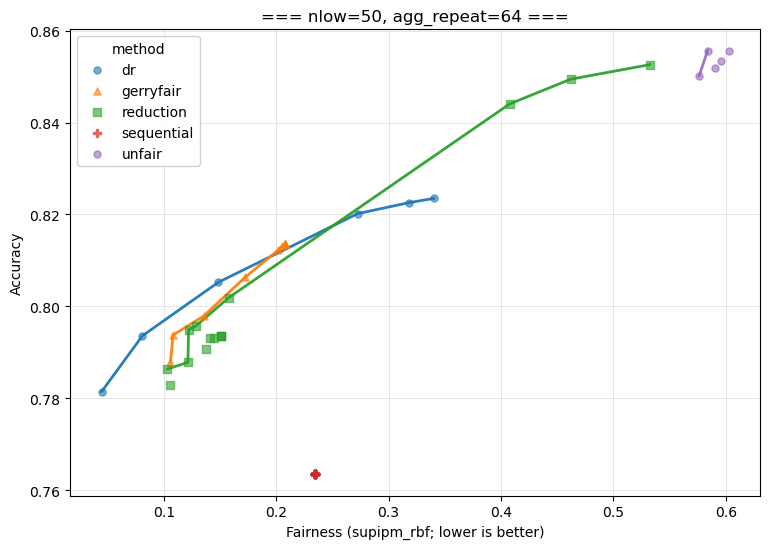

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=50, agg_repeat=256 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

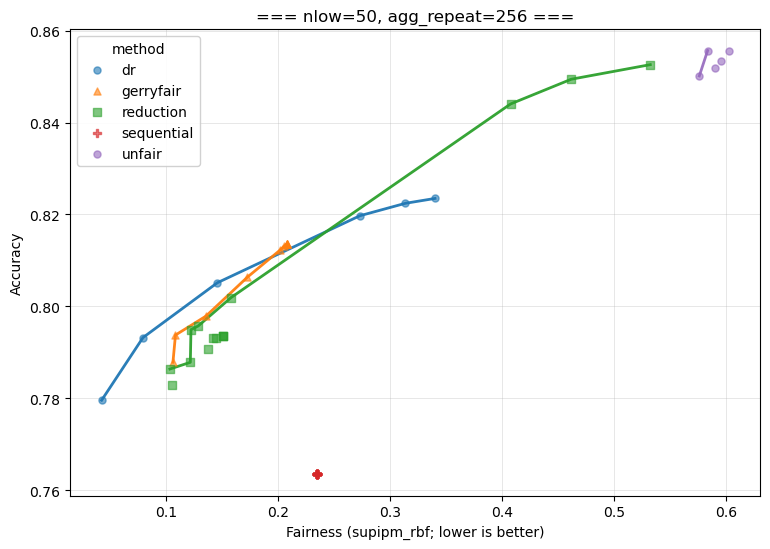

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=50, agg_repeat=1024 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

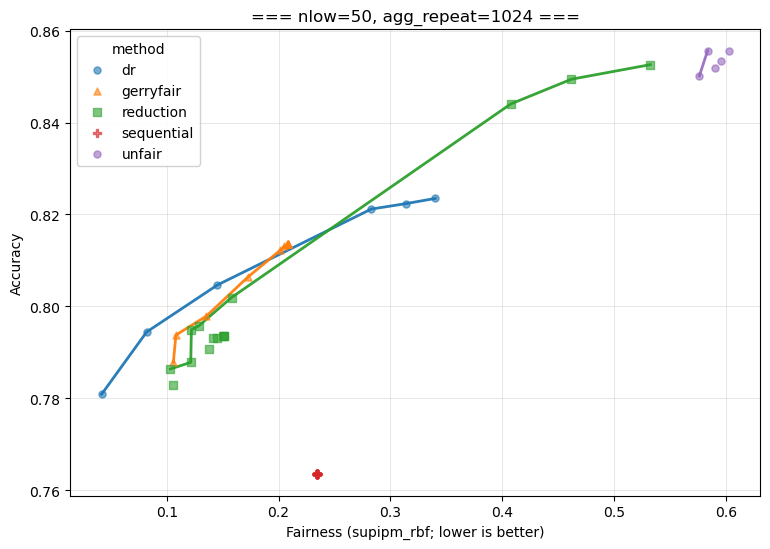

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=50, agg_repeat=4096 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

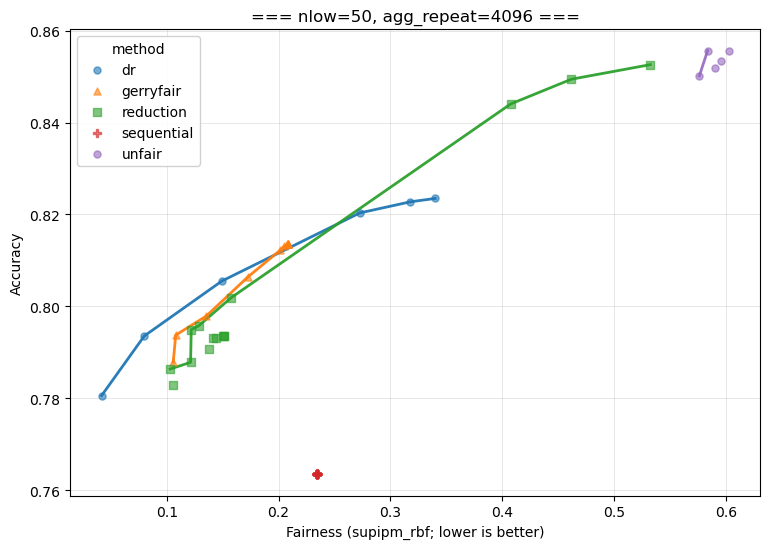

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=100, agg_repeat=4 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

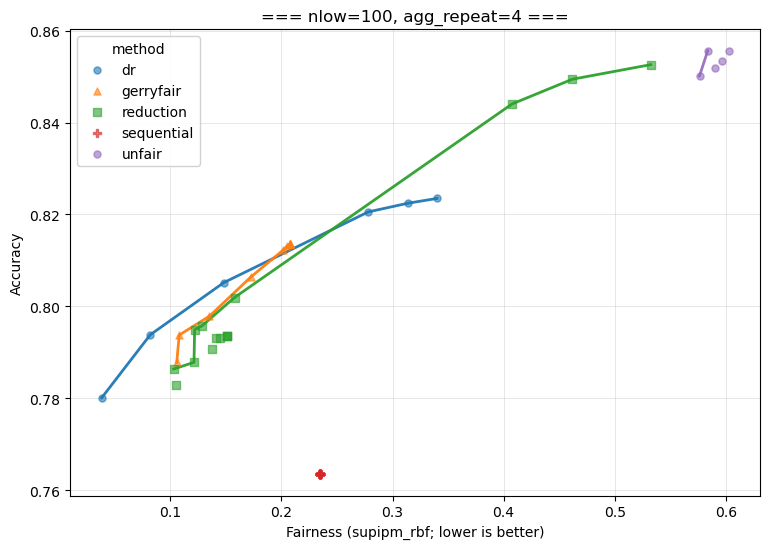

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=100, agg_repeat=16 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

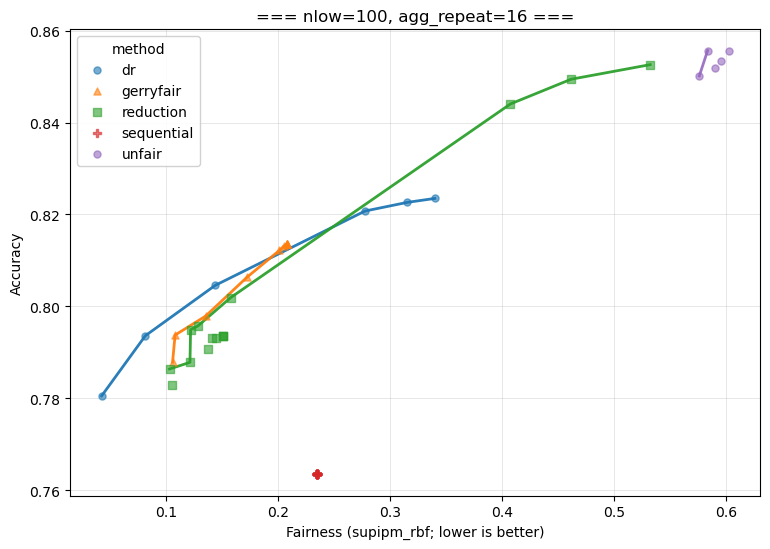

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=100, agg_repeat=64 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

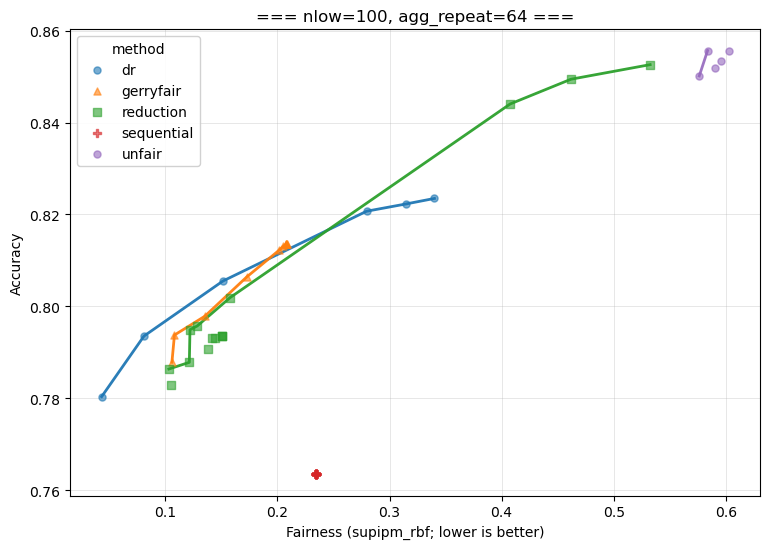

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=100, agg_repeat=256 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

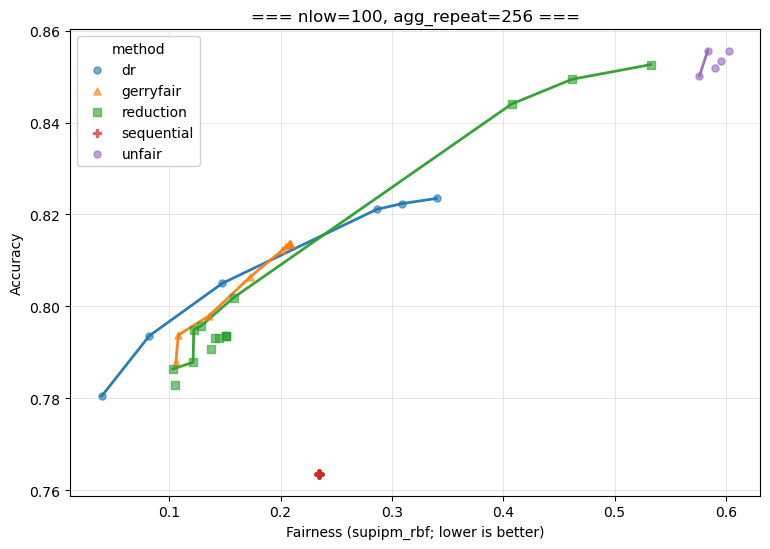

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=100, agg_repeat=1024 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

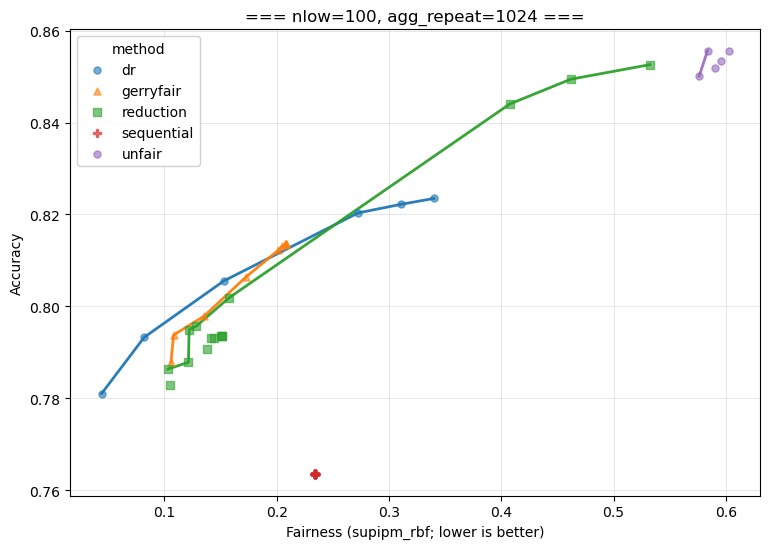

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=100, agg_repeat=4096 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

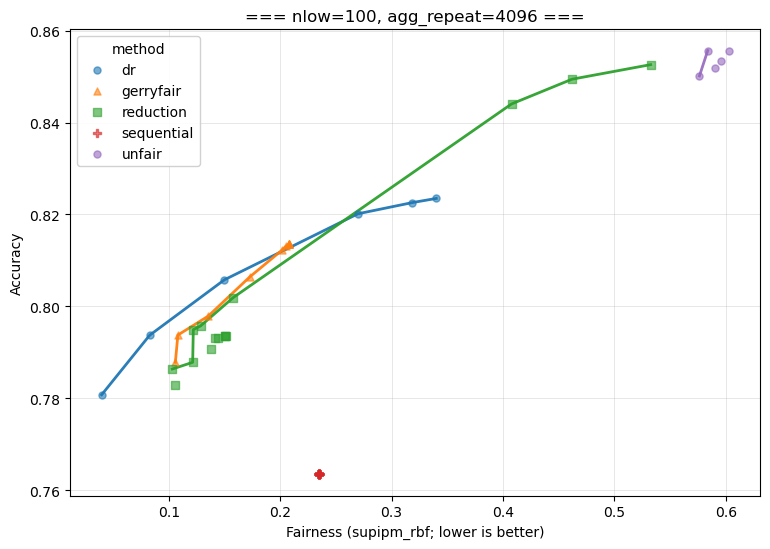

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=200, agg_repeat=4 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

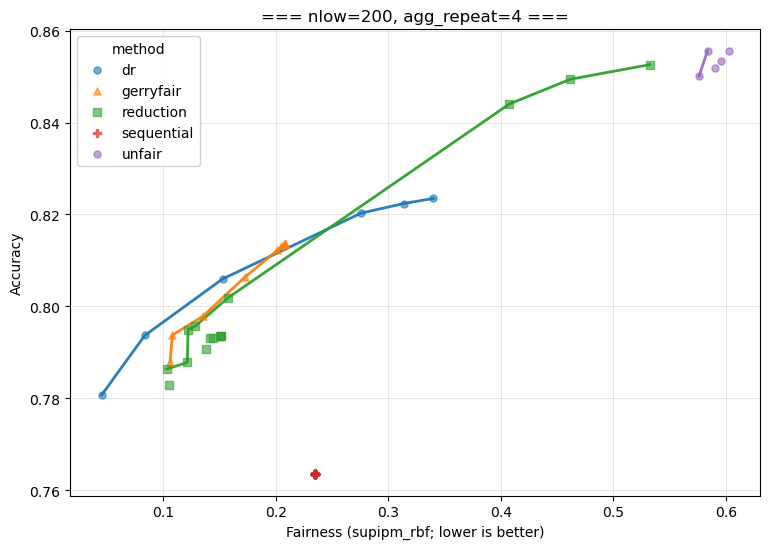

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=200, agg_repeat=16 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

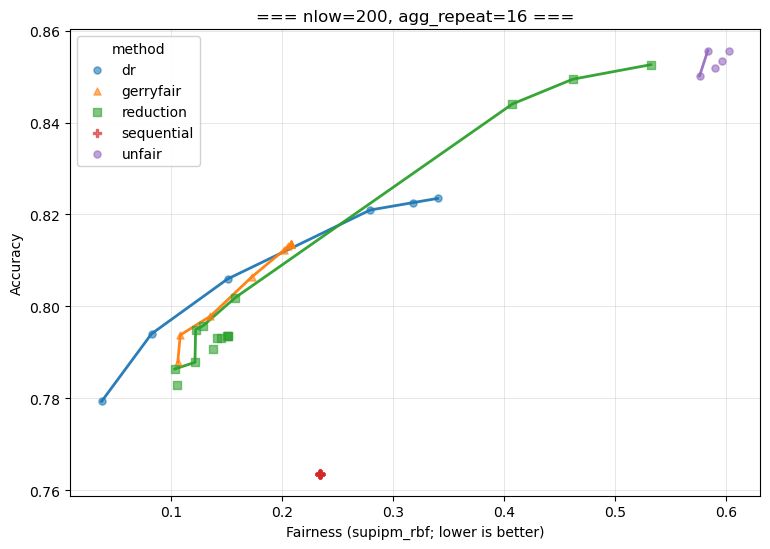

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=200, agg_repeat=64 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

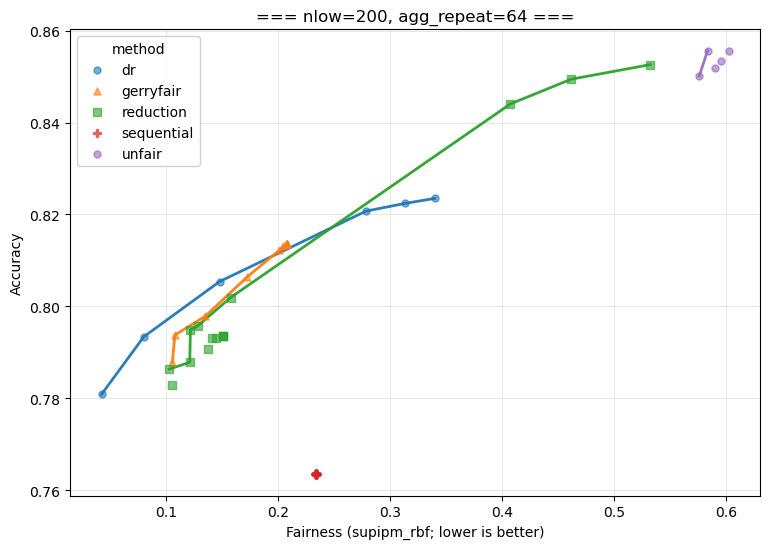

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=200, agg_repeat=256 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

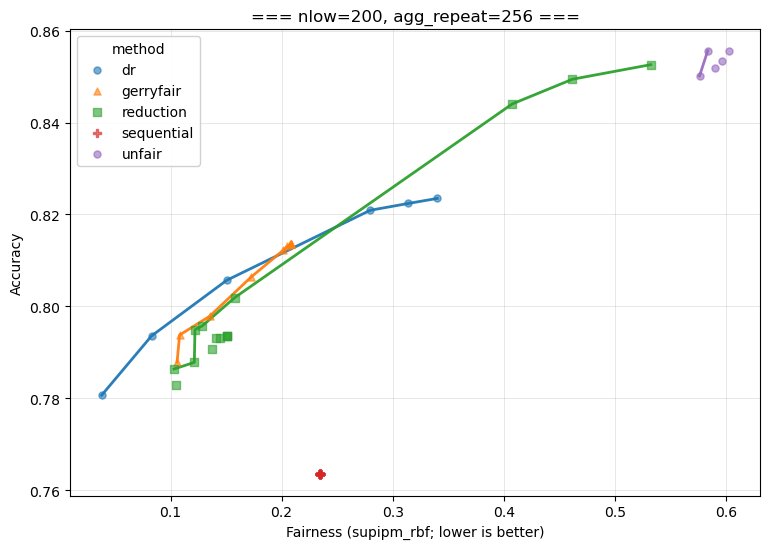

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=200, agg_repeat=1024 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

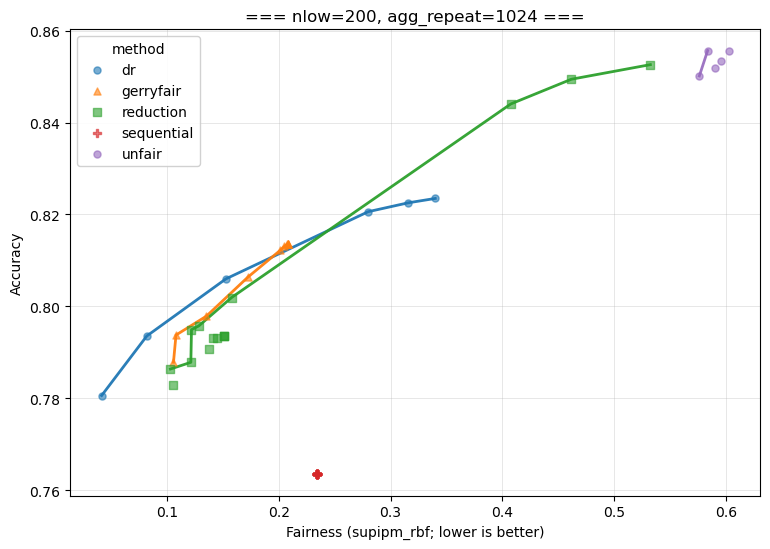

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=200, agg_repeat=4096 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

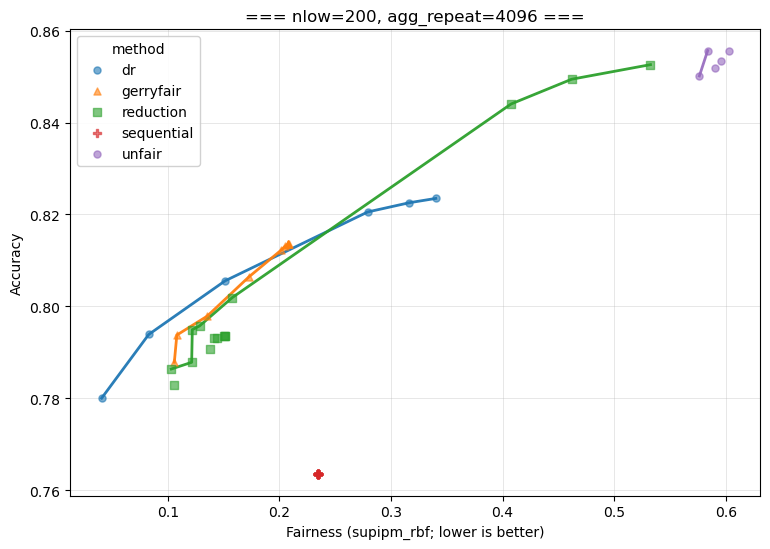

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=400, agg_repeat=4 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

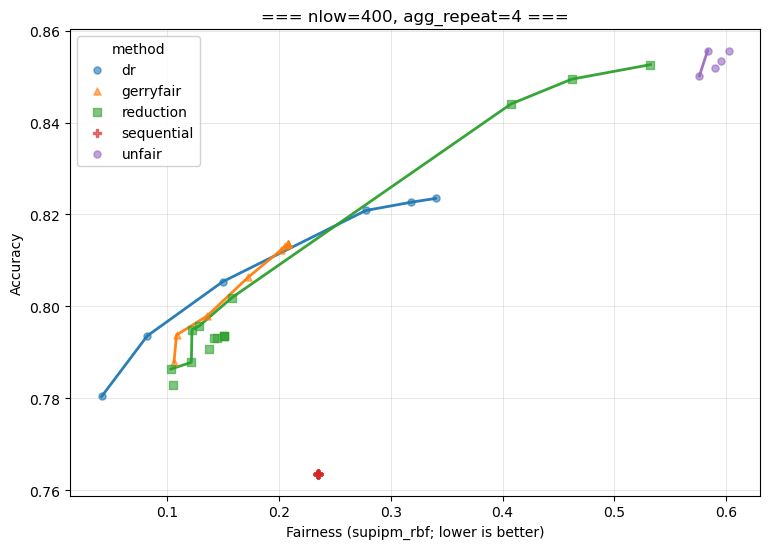

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=400, agg_repeat=16 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

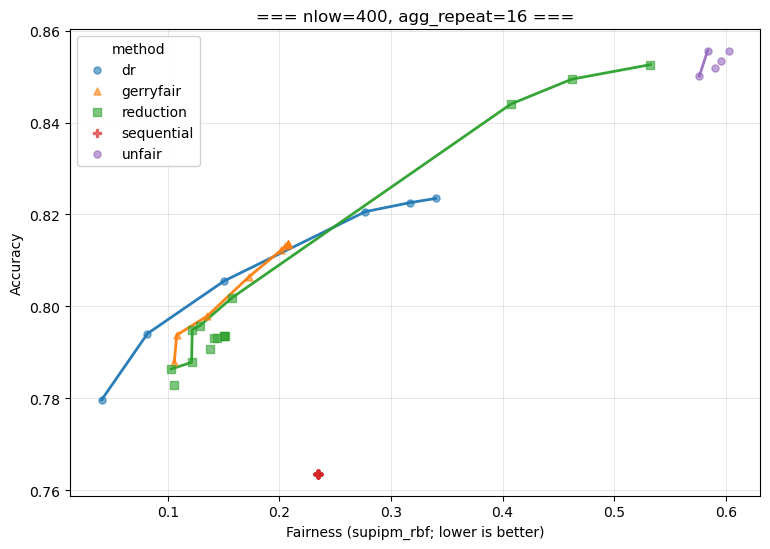

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=400, agg_repeat=64 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

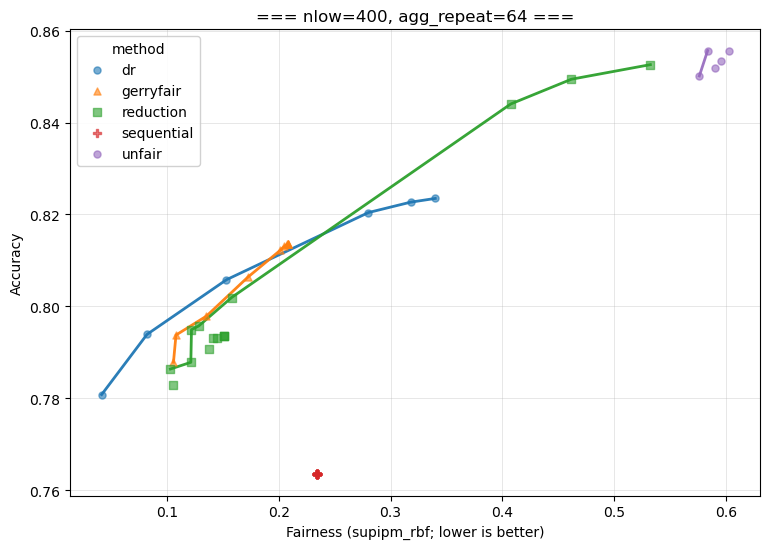

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=400, agg_repeat=256 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha
[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

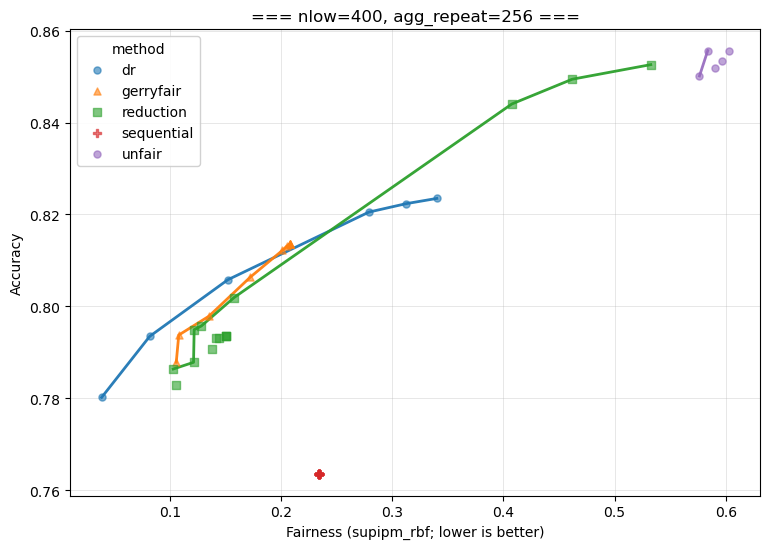

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=400, agg_repeat=1024 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

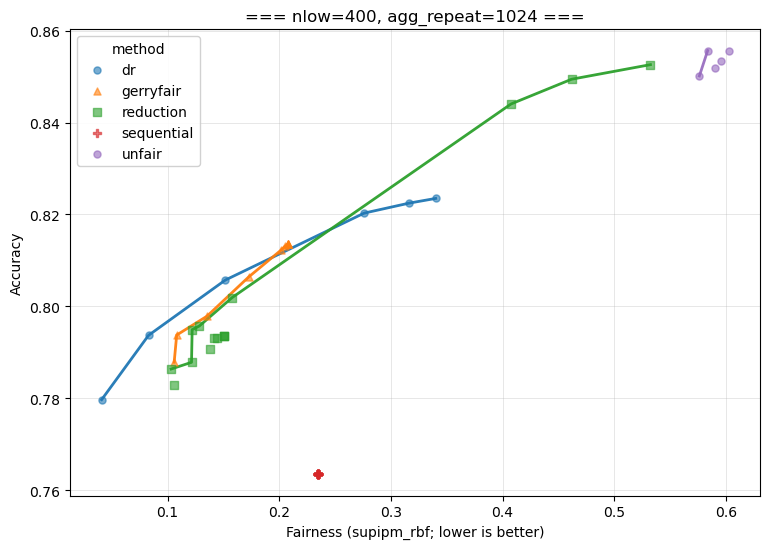

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png
=== nlow=400, agg_repeat=4096 ===
[INFO] loaded rows=250, files=5
[INFO] methods(raw): ['dr_subgroup_subset_random', 'gerryfair', 'reduction', 'sequential', 'unfair']
[INFO] method=dr_subgroup_subset_random
[INFO] method=dr_subgroup_subset_random -> base=         dr, ctrl=lambda_fair
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C
[INFO] method=               reduction
[INFO] method=               reduction -> base=  reduction, ctrl=red_eps
[INFO] method=              sequential
[INFO] method=              sequential -> base= sequential, ctrl=seq_alpha


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(
/tmp/ip

[INFO] method=                  unfair
[INFO] method=                  unfair -> base=     unfair, ctrl=None


<Figure size 640x480 with 0 Axes>

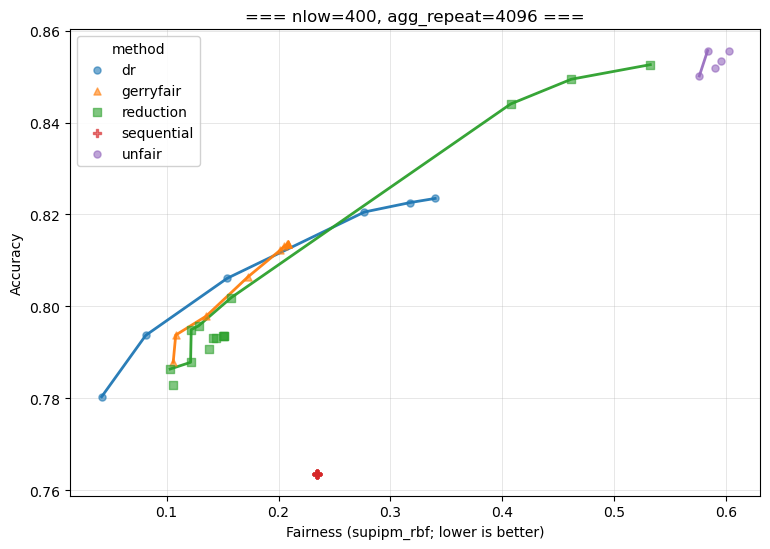

[INFO] saved -> ../plots/tradeoff/adult_supipm_rbf.png


<Figure size 640x480 with 0 Axes>

In [79]:
DATASET = "adult"
for nlow in [10,20,50, 100,200,400]:
    for agg_repeat in [4, 16, 64, 256, 1024, 4096]:
        print(f"=== nlow={nlow}, agg_repeat={agg_repeat} ===")
        main(DATASET, nlow, agg_repeat, title = f"=== nlow={nlow}, agg_repeat={agg_repeat} ===", path = "../plots/tradeoff/")

=== nlow=10, agg_repeat=4 ===
[INFO] loaded rows=55, files=1
[INFO] methods(raw): ['gerryfair']
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(


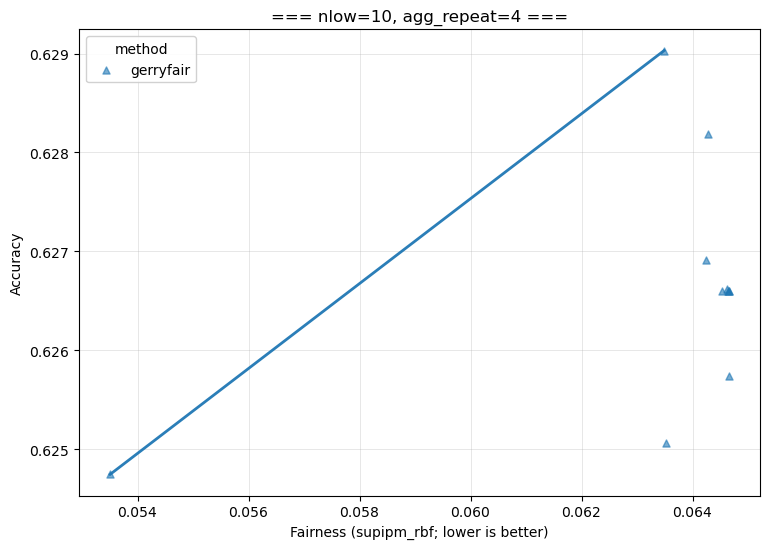

[INFO] saved -> ../plots/tradeoff/dutch_supipm_rbf.png
=== nlow=20, agg_repeat=4 ===
[INFO] loaded rows=55, files=1
[INFO] methods(raw): ['gerryfair']
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(


<Figure size 640x480 with 0 Axes>

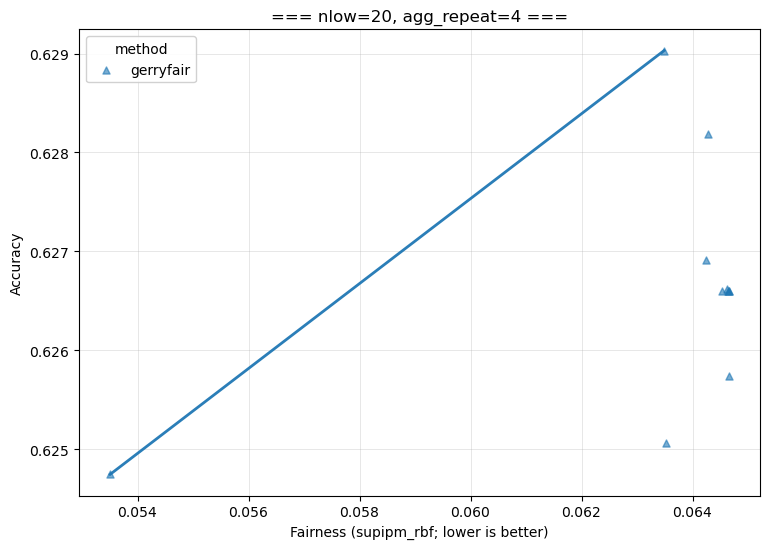

[INFO] saved -> ../plots/tradeoff/dutch_supipm_rbf.png
=== nlow=50, agg_repeat=4 ===
[INFO] loaded rows=55, files=1
[INFO] methods(raw): ['gerryfair']
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(


<Figure size 640x480 with 0 Axes>

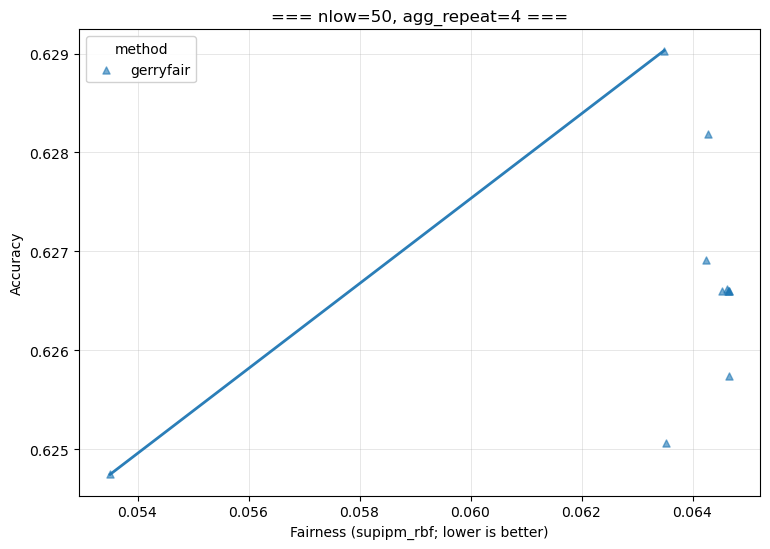

[INFO] saved -> ../plots/tradeoff/dutch_supipm_rbf.png
=== nlow=100, agg_repeat=4 ===
[INFO] loaded rows=55, files=1
[INFO] methods(raw): ['gerryfair']
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(


<Figure size 640x480 with 0 Axes>

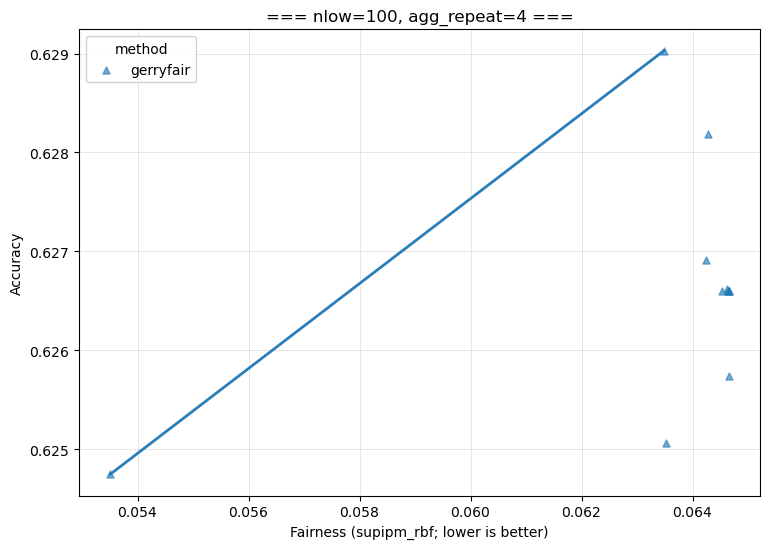

[INFO] saved -> ../plots/tradeoff/dutch_supipm_rbf.png
=== nlow=200, agg_repeat=4 ===
[INFO] loaded rows=55, files=1
[INFO] methods(raw): ['gerryfair']
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(


<Figure size 640x480 with 0 Axes>

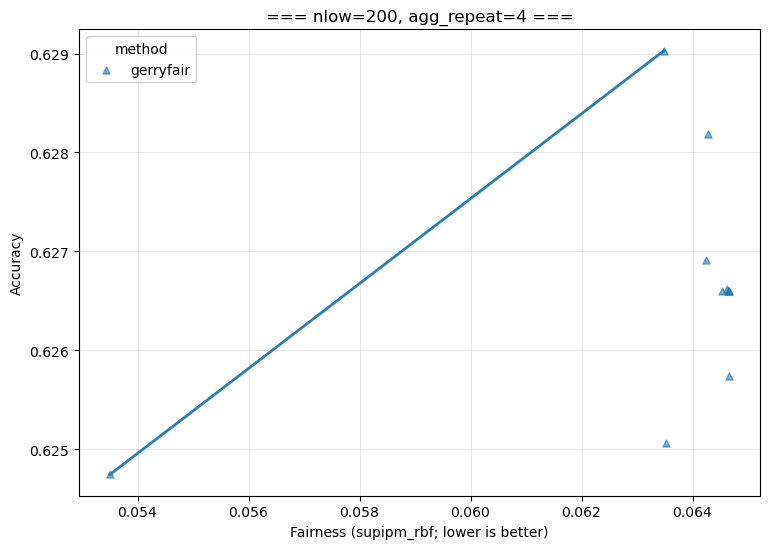

[INFO] saved -> ../plots/tradeoff/dutch_supipm_rbf.png
=== nlow=400, agg_repeat=4 ===
[INFO] loaded rows=55, files=1
[INFO] methods(raw): ['gerryfair']
[INFO] method=               gerryfair
[INFO] method=               gerryfair -> base=  gerryfair, ctrl=gf_C


/tmp/ipykernel_1047586/2488976035.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", max(10, len(base_methods)))
/tmp/ipykernel_1047586/2488976035.py:230: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grp = sub.groupby([ctrl, "seed"], dropna=False).agg(
/tmp/ipykernel_1047586/2488976035.py:235: FutureWarning: The provided callable <function mean at 0x7f8cd827d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = grp.groupby("ctrl", dropna=False).agg(


<Figure size 640x480 with 0 Axes>

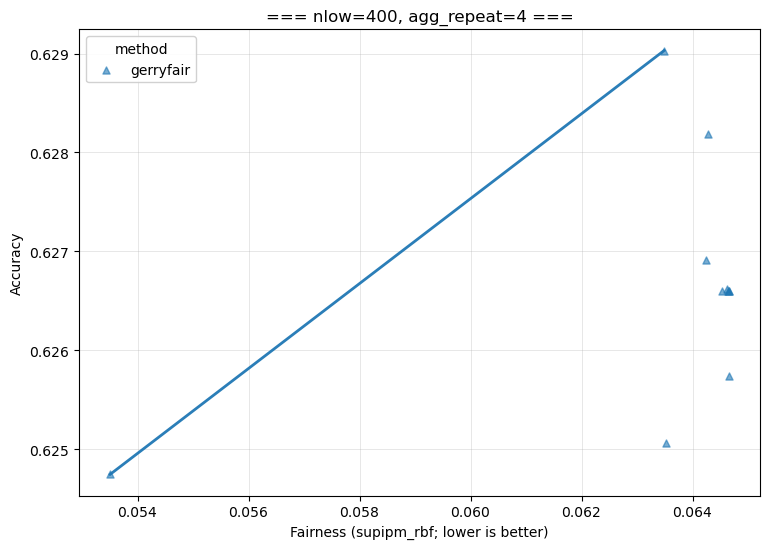

[INFO] saved -> ../plots/tradeoff/dutch_supipm_rbf.png


<Figure size 640x480 with 0 Axes>

In [81]:
DATASET = "dutch"
for nlow in [10, 20, 50, 100,200,400]:
    for agg_repeat in [4]:
        print(f"=== nlow={nlow}, agg_repeat={agg_repeat} ===")
        main(DATASET, nlow, agg_repeat, title = f"=== nlow={nlow}, agg_repeat={agg_repeat} ===", path = "../plots/tradeoff/")